In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install "dask[dataframe]"
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!apt-get -V -y -qq install python-cartopy python3-cartopy

In [4]:
!pip uninstall shapely -y

Found existing installation: Shapely 1.6.4
Uninstalling Shapely-1.6.4:
  Successfully uninstalled Shapely-1.6.4


In [5]:
!pip install shapely --no-binary shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 200 kB 7.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for shapely: filename=Shapely-1.8.5.post1-cp37-cp37m-linux_x86_64.whl size=669741 sha256=534e6671181be8be552372f5ea53ae1594e116a5d8a9f622082f170696c5ae9b
  Stored in directory: /root/.cache/pip/wheels/a3/07/7c/cc50e8ecc795963726466b22ecd395ee1e2a28da87a4cdeb56
Successfully built shapely


In [6]:
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
import cartopy
import cartopy.crs as ccrs
from cartopy import feature as cf
import matplotlib.pyplot as plt
from matplotlib import cm
from netCDF4 import Dataset,num2date
from shapely.geometry import Point
from matplotlib.colors import LinearSegmentedColormap
np.warnings.filterwarnings('ignore')


%matplotlib inline

In [7]:
# norm_data = pd.read_csv("/content/drive/MyDrive/Private/Image_Similarity/daily_trans_norm.csv")
# trans_data = norm_data.iloc[:,1:]
# trans_data

In [58]:
path2 = ('/content/drive/MyDrive/Data/ERA5_meteo_sfc_2021_daily.nc')
data = xr.open_dataset(path2, decode_times=False) #To view the date as integers of 0, 1, 2,....
data

<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 ...
    sst        (time, latitude, longitude) float64 ...
    u10        (time, latitude, longitude) float64 ...
    v10        (time, latitude, longitude) float64 ...
    sshf       (time, latitude, longitude) float64 ...
    slhf       (time, latitude, longitude) float64 ...
    t2m        (time, latitude, longitude) float64 ...
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [59]:
  #Function to detect the presence of null values in 4-d xarray
  def detect_null(input):
    for i in input.data_vars:
      if input[i].isnull().sum().item() > 0:
        print('Missing value detected in variable', i)
    return input

In [60]:
detect_null(data)

Missing value detected in variable sst


<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float32 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float32 43.0 42.75 42.5 42.25 ... 33.5 33.25 33.0
Data variables:
    sp         (time, latitude, longitude) float64 1.024e+05 ... 1.011e+05
    sst        (time, latitude, longitude) float64 290.1 290.0 ... 293.4 293.3
    u10        (time, latitude, longitude) float64 -4.228 -4.348 ... 6.268 5.776
    v10        (time, latitude, longitude) float64 6.211 6.16 ... 8.584 8.798
    sshf       (time, latitude, longitude) float64 -5.477e+04 ... 2.513e+03
    slhf       (time, latitude, longitude) float64 -3.669e+05 ... -3.581e+05
    t2m        (time, latitude, longitude) float64 288.6 288.4 ... 293.1 293.1
Attributes:
    title:          Daily variables from ERA5 hourly data
    history:        Wed Mar 23 12:01:11 2022: ncrcat ERA5_meteo_sfc_2021_01-0...
    Input dataset:  /global/cscratch1/sd/xzheng/ENA/rawdata/ERA5_meteo_sfc_20...
    NCO:            netCDF Operators version 5.0.1 (Homepage = http://nco.sf....

In [61]:
var = []
for i in data:
  var.append(i)
print (var)

['sp', 'sst', 'u10', 'v10', 'sshf', 'slhf', 't2m']


In [62]:
# plt.contourf(data['sst'][0,:,:])
# plt.colorbar()

Let's have a map visualization of sst.

In [63]:
sst = data.sst
t2m = data.t2m
sp = data.sp
u10 = data.u10
v10 = data.v10
sshf = data.sshf
slhf = data.slhf

In [64]:
sst.shape

(365, 41, 41)

Set some color breaks

define a color palette

In [65]:
# jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

set color scale using the jet palette

In [66]:
# cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))

In [67]:
dates=nc.num2date(data.time,data.time.units,only_use_cftime_datetimes=False) #Read date in datetime format so we can strip date
strDate = dates[0] #Initialize the startdate

plot the SST map

In [68]:
#da=data.sel(latitude=sst.latitude, longitude=sst.longitude)

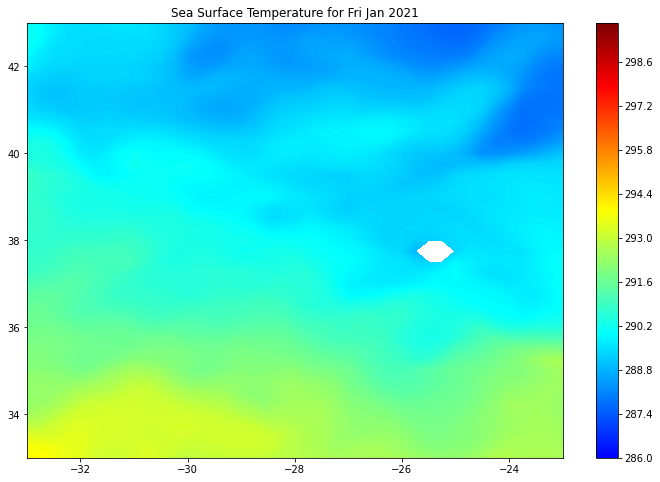

In [69]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

levs = np.arange(286.0, 299.9, 0.05)
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(data.longitude, data.latitude, data.sst[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("Sea Surface Temperature for " + dates[0].strftime('%a %b %Y'))
plt.show()

Creating a map of average SST over a year

In [ ]:
mean_sst=np.mean(data.sst,axis=0)
mean_sst.shape

In [ ]:
plt.contourf(data.longitude, data.latitude, mean_sst, levs,cmap=cm)
plt.colorbar()
plt.title("Mean SST " + dates[0].strftime('%Y-%m')+' - '+dates[11].strftime('%Y-%m'))
plt.show()

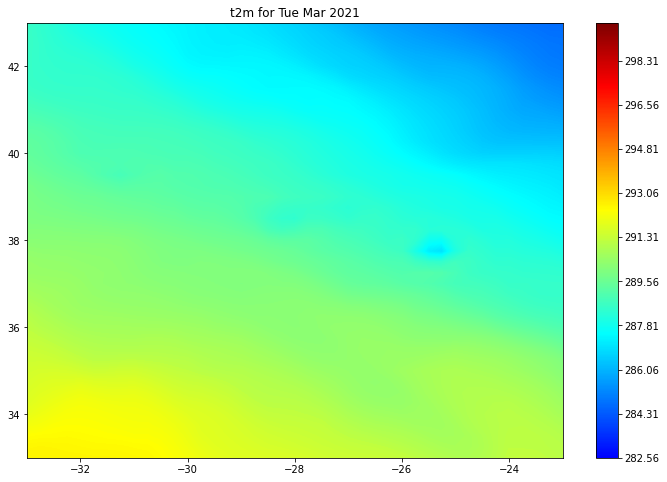

In [20]:
#np.nanmin(t2m), np.nanmax(t2m)(281.3474503204954, 298.9880612987922)
levs = np.arange(282.56, 299.818, 0.05)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(data.longitude, data.latitude, t2m[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("t2m for " + dates[67].strftime('%a %b %Y'))
plt.show()

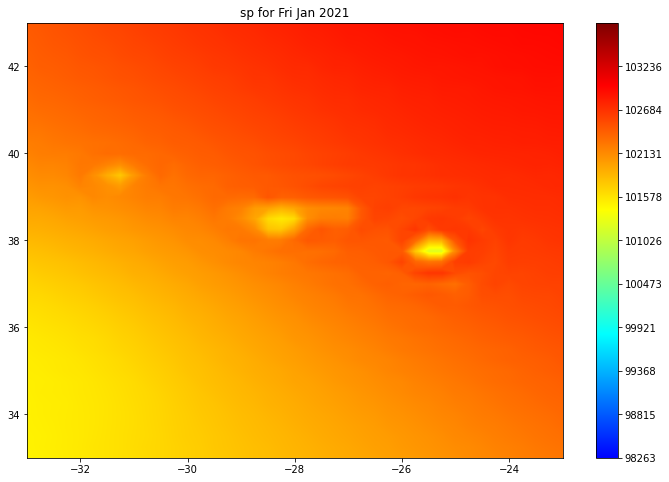

In [21]:
levs = np.arange(98262.56, 103788.818, 0.05) #(98261.56519393537, 103787.81869853102)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(data.longitude, data.latitude, sp[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("sp for " + dates[0].strftime('%a %b %Y'))
plt.show()

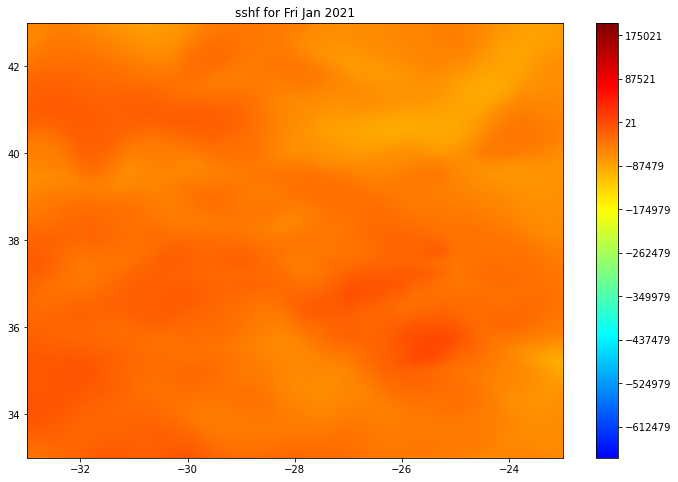

In [22]:
#np.nanmin(sshf), np.nanmax(sshf) (-674528.4583415989, 200023.0888483665)
levs = np.arange(-674529.45, 200024.08, 50)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
plt.contourf(data.longitude, data.latitude, sshf[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("sshf for " + dates[0].strftime('%a %b %Y'))
plt.show()


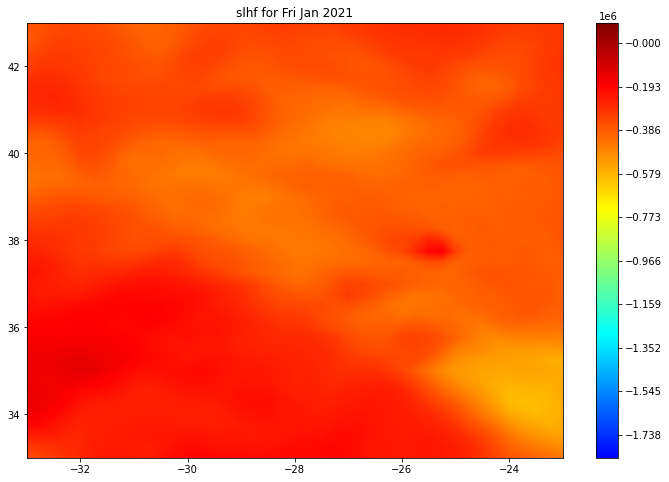

In [23]:
#np.nanmin(slhf), np.nanmax(slhf) (-1840906.950435913, 90130.6519768666)
levs = np.arange(-1840906.95, 90130.65, 50)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
plt.contourf(data.longitude, data.latitude, slhf[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("slhf for " + dates[0].strftime('%a %b %Y'))
plt.show()


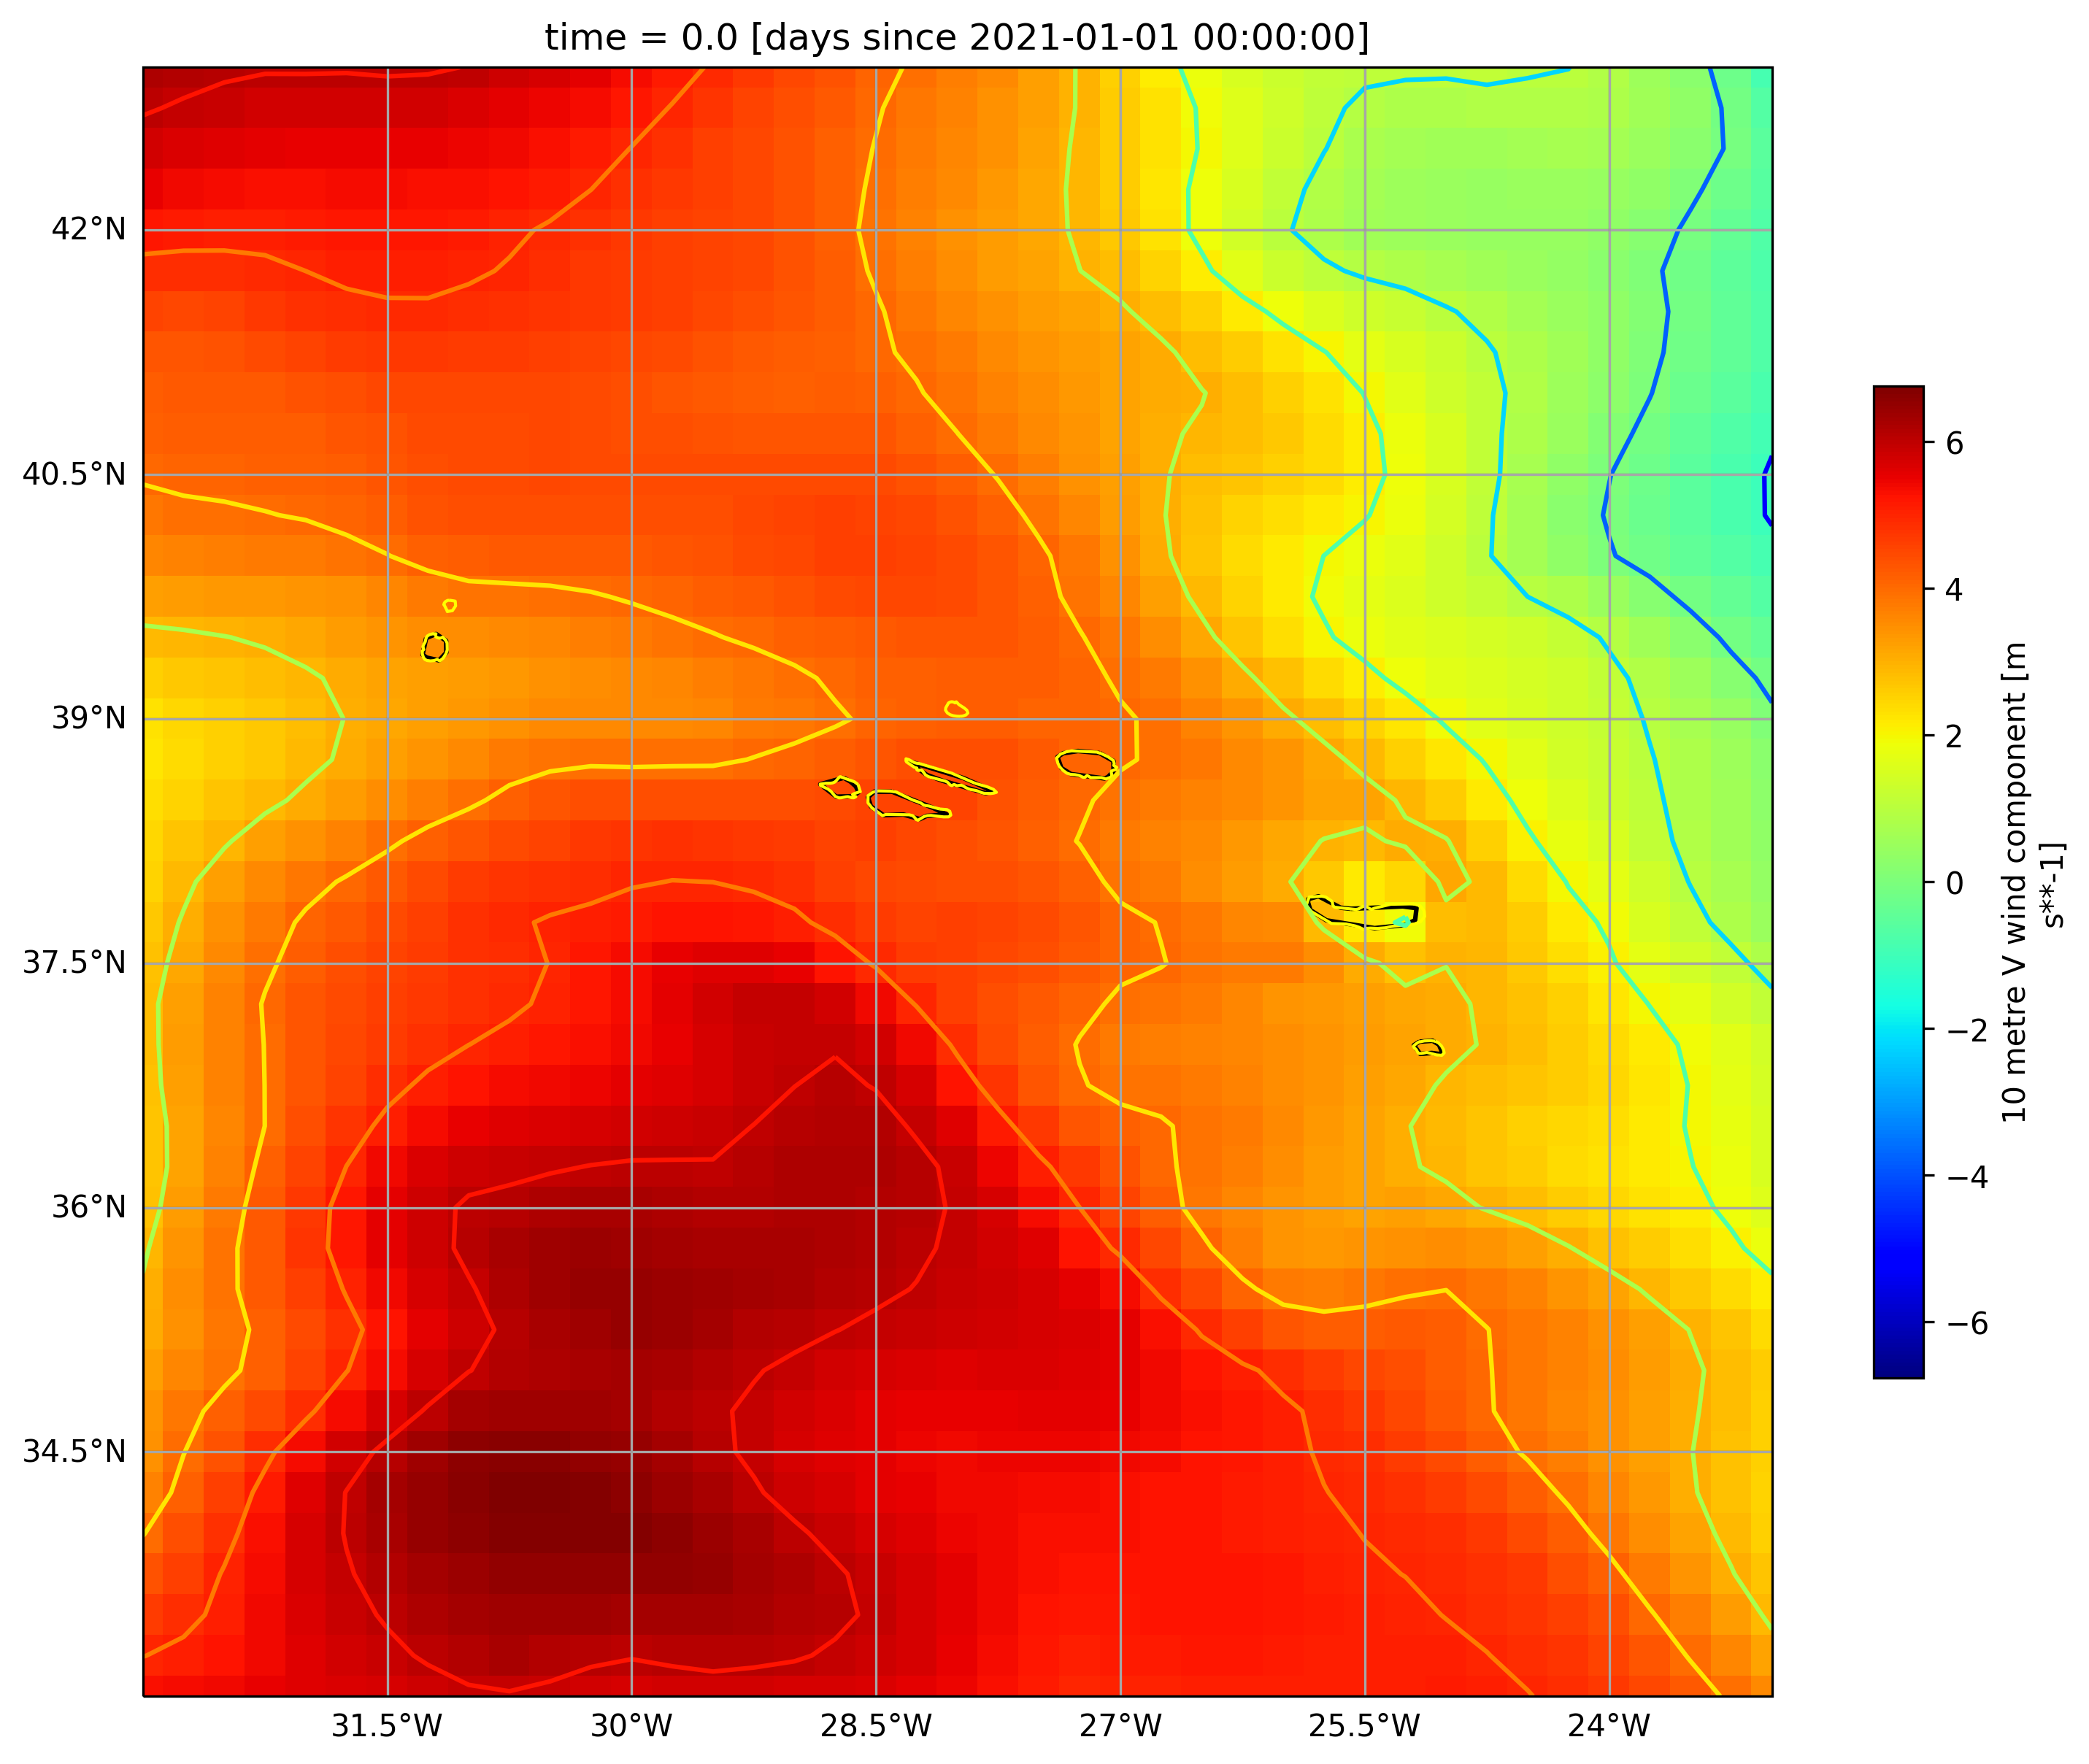

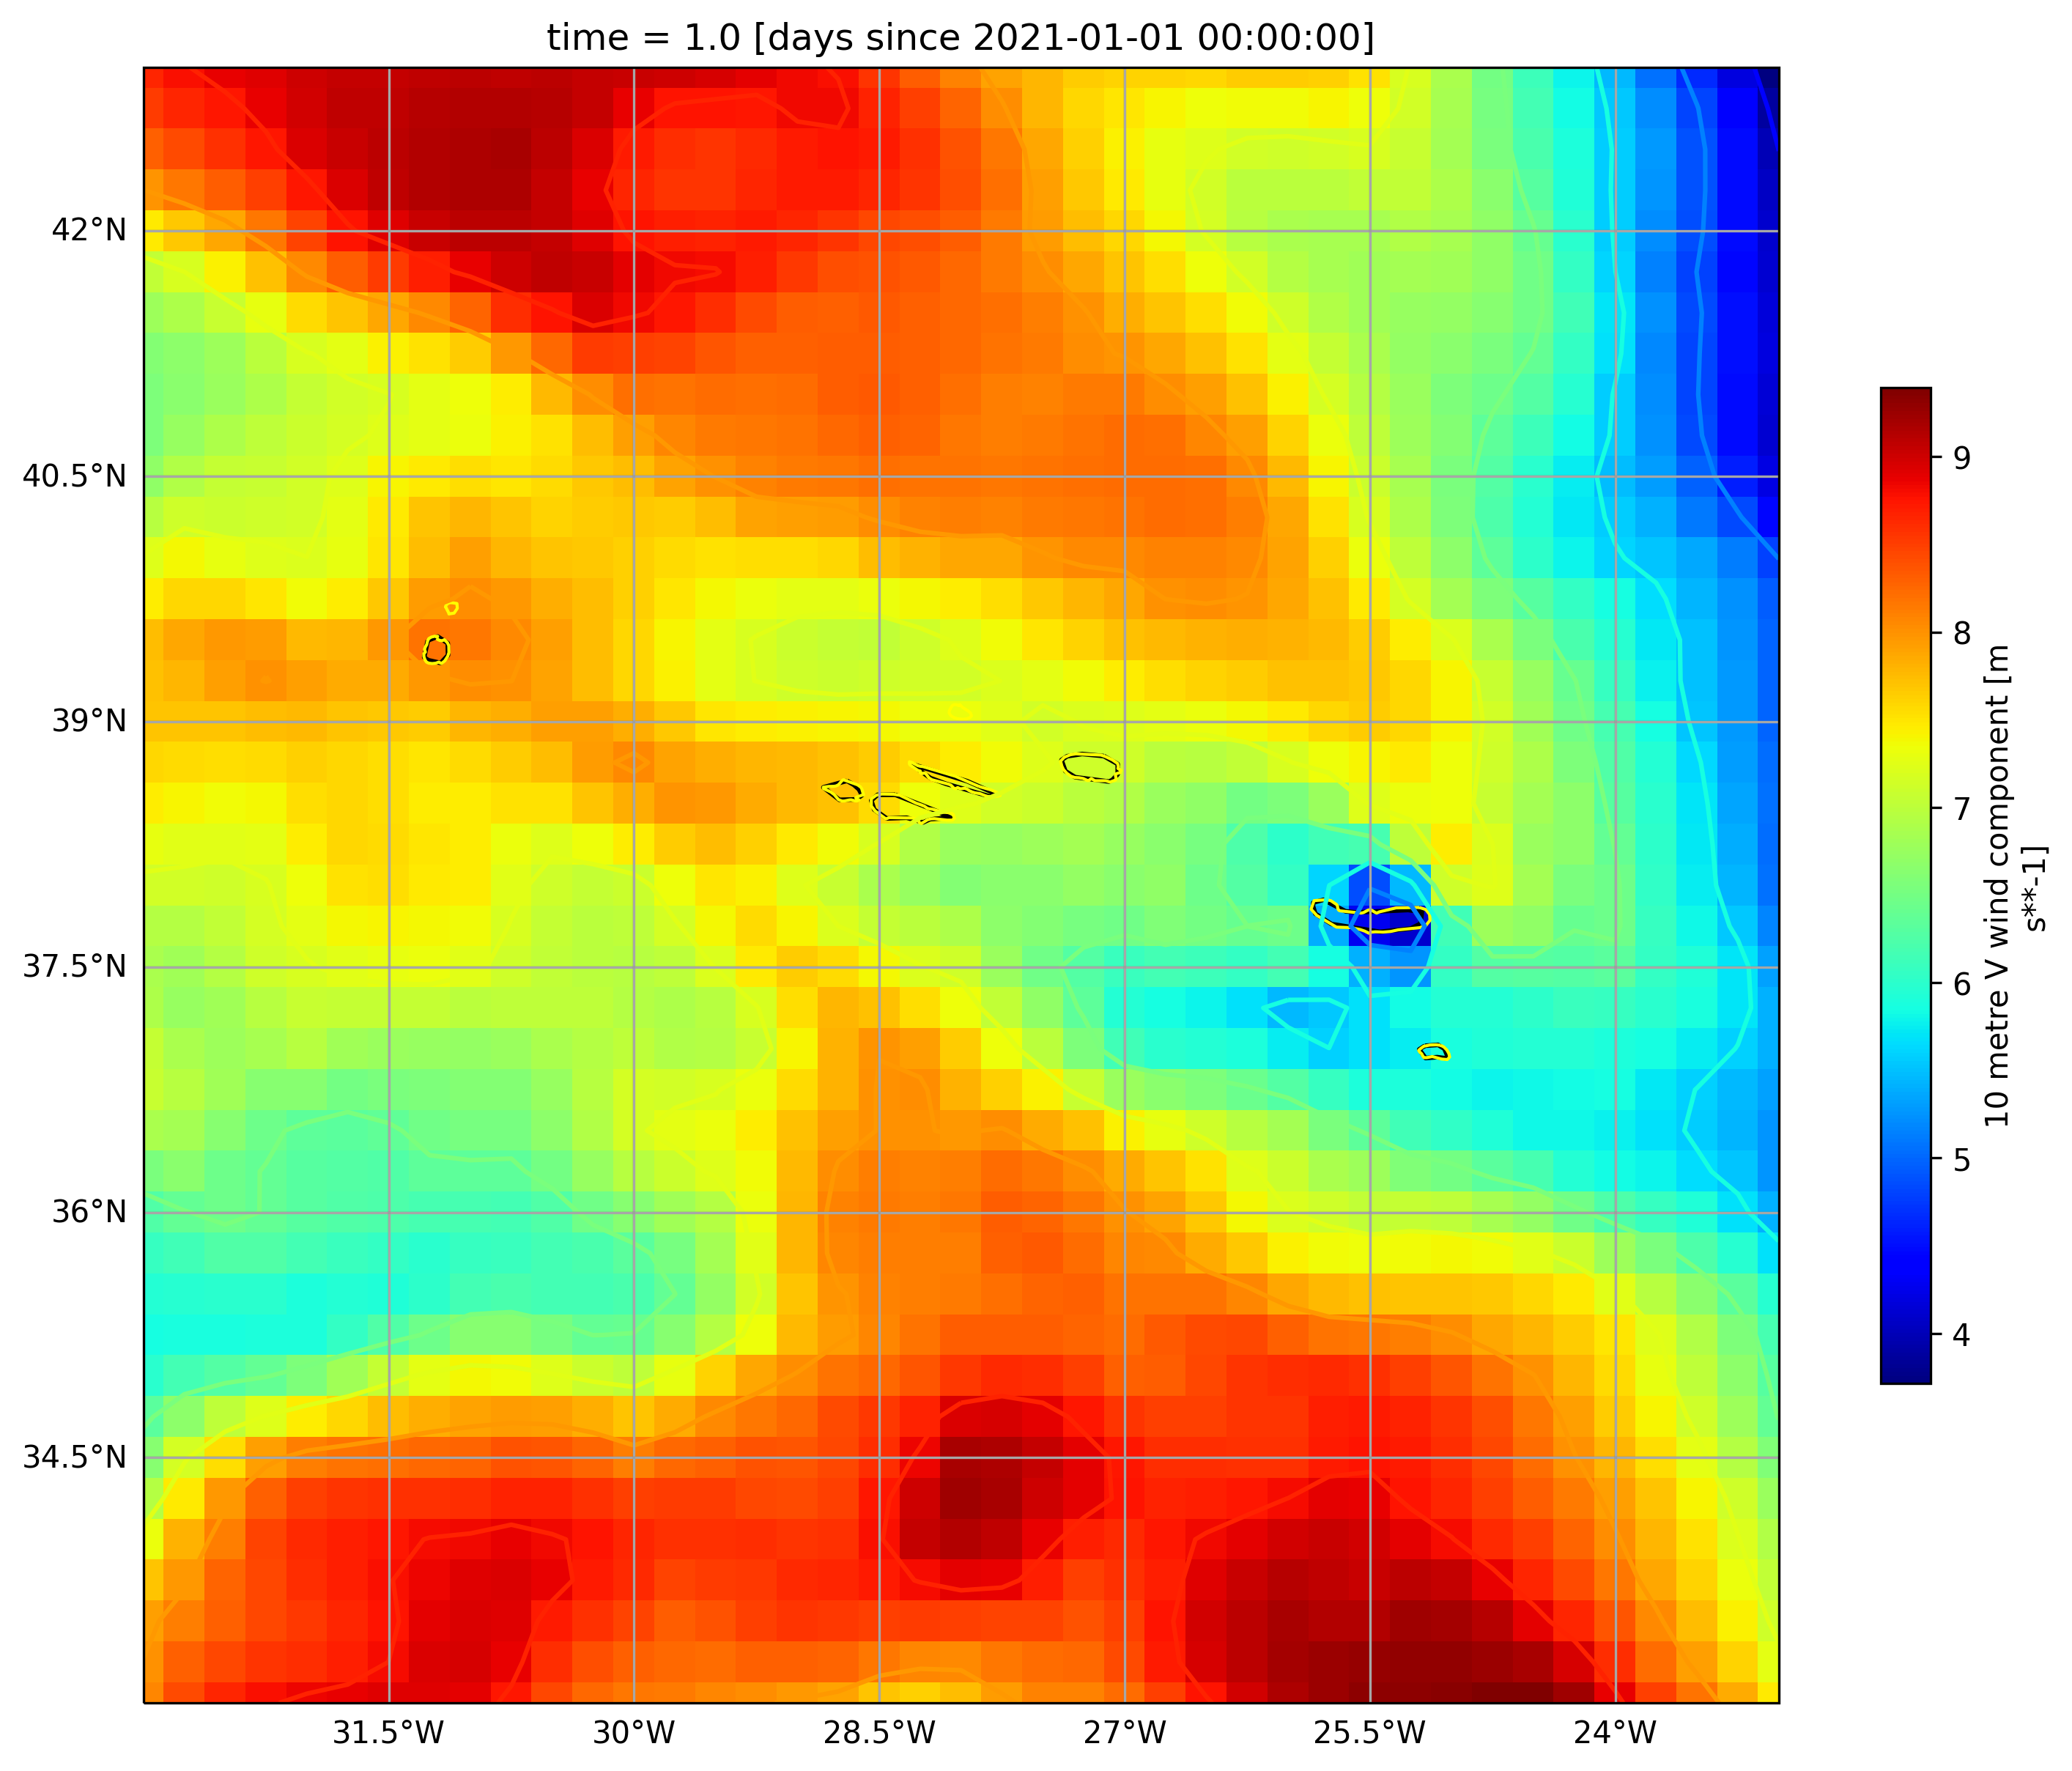

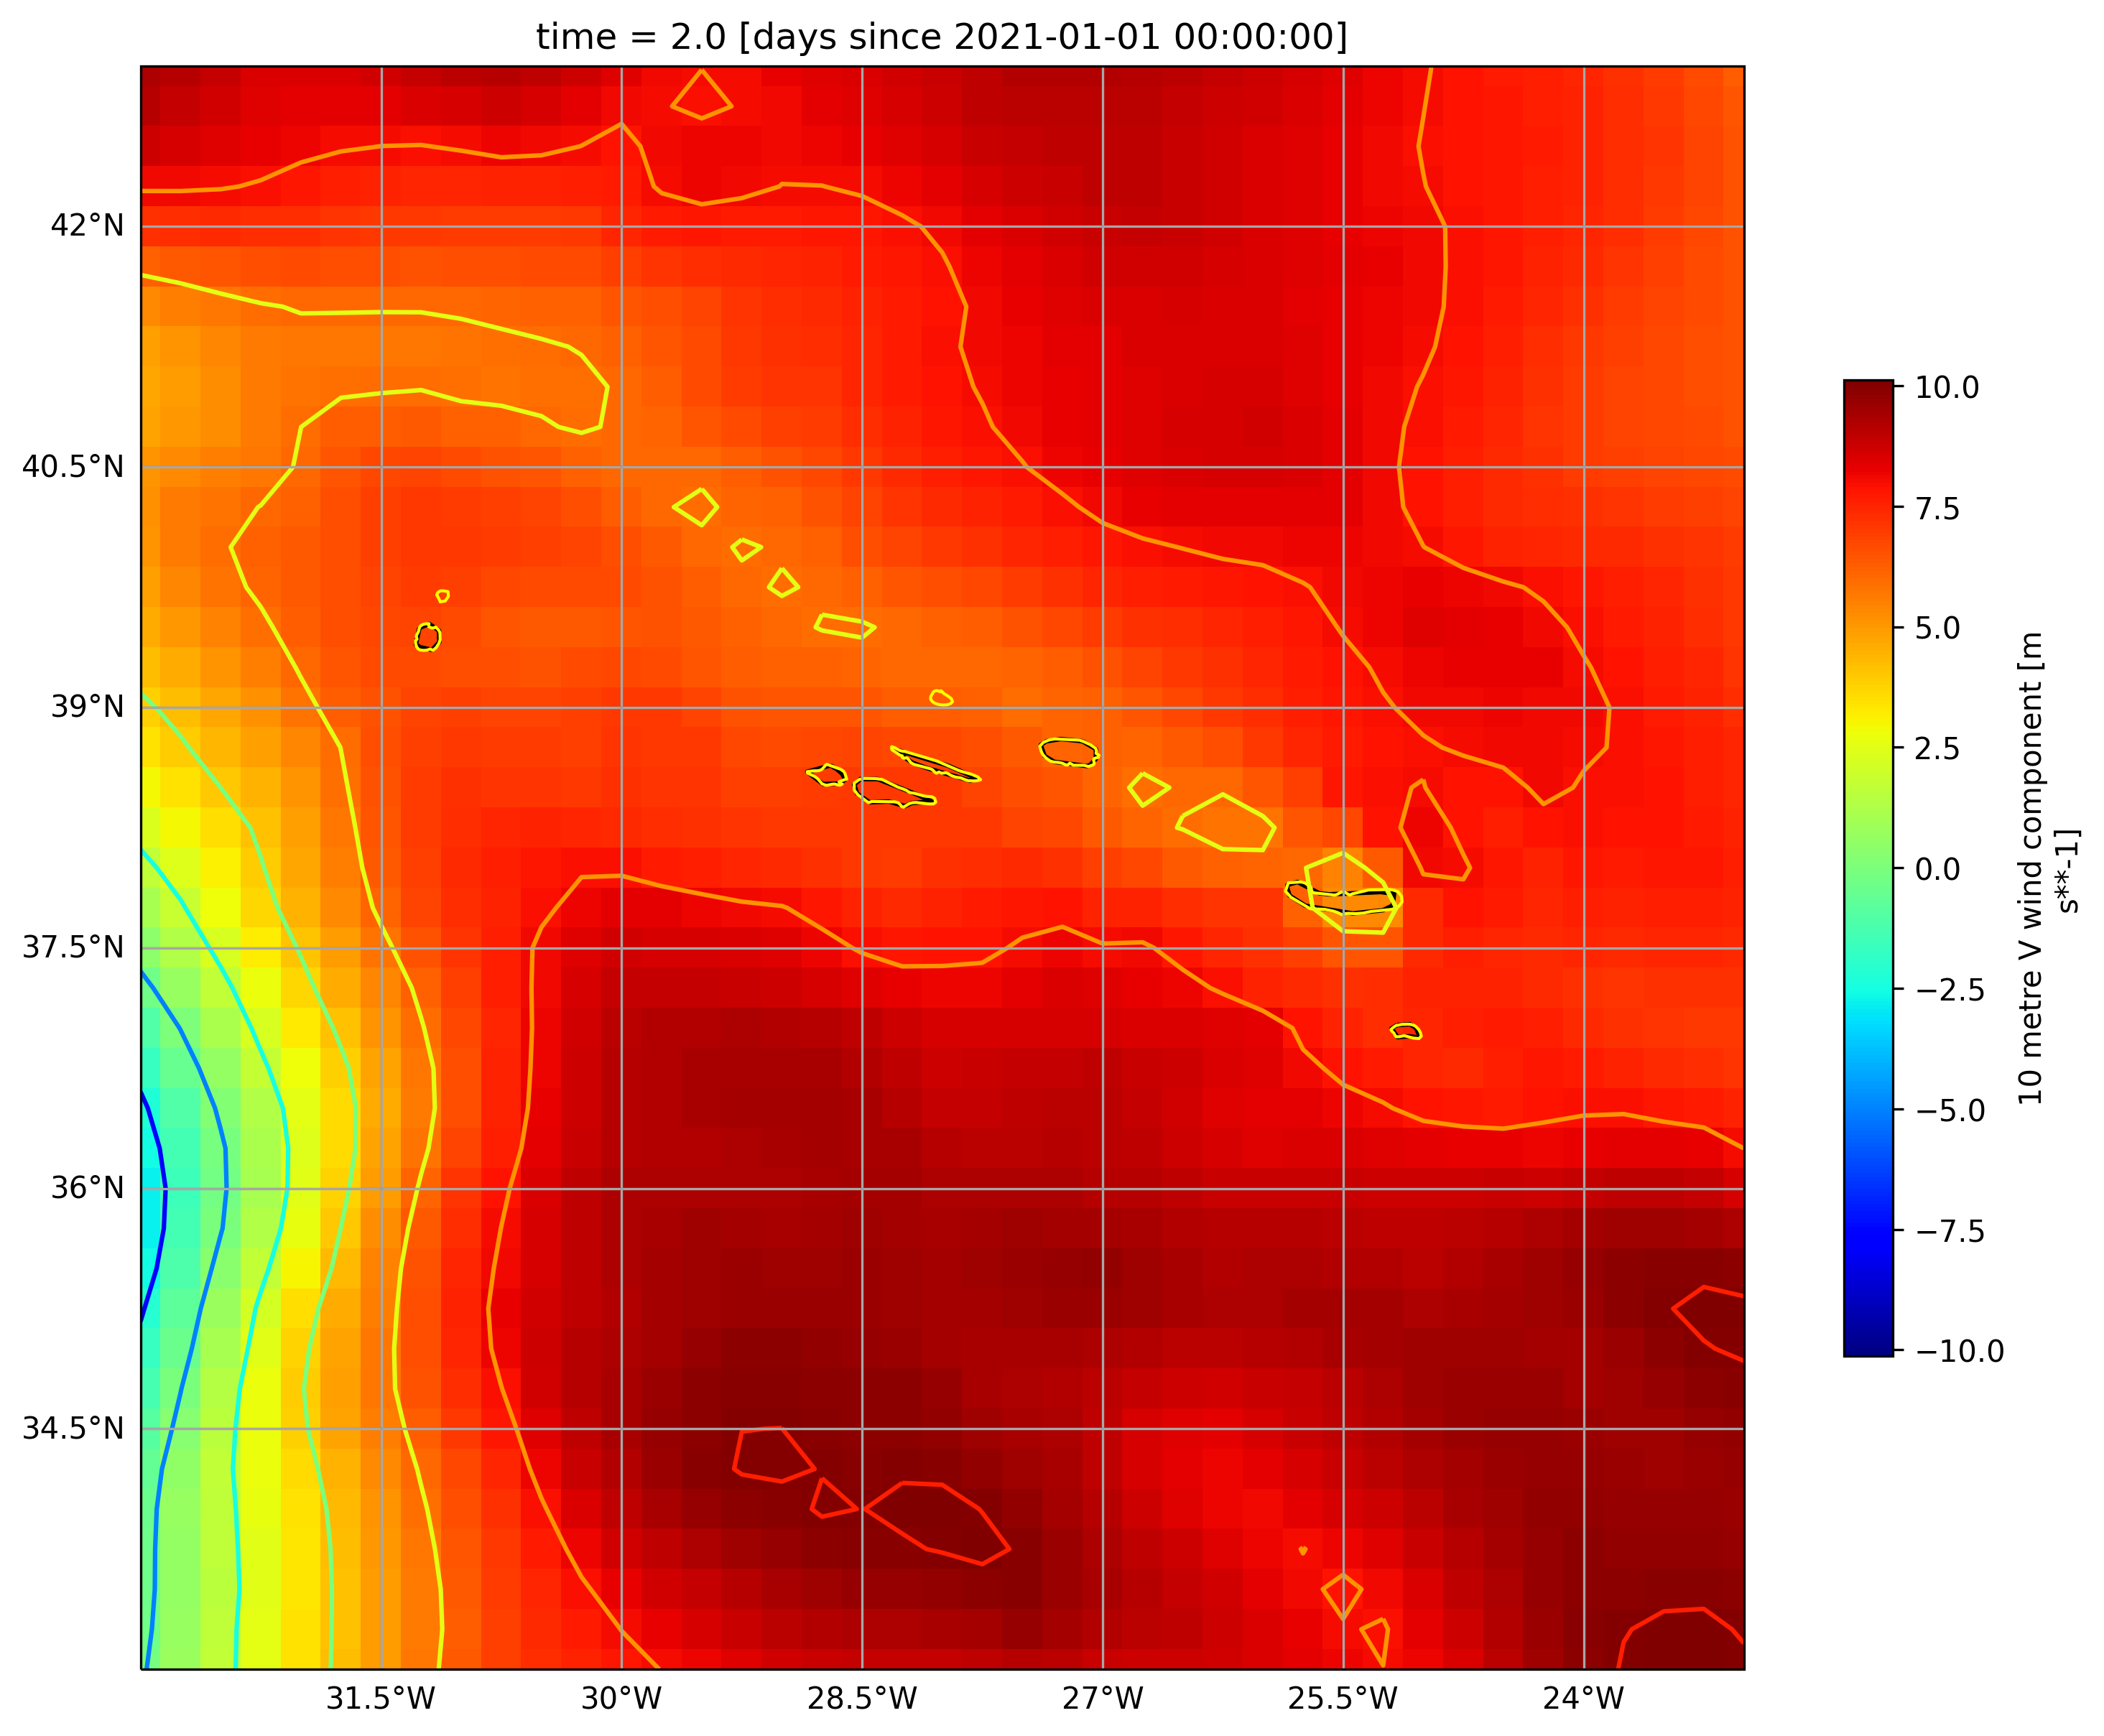

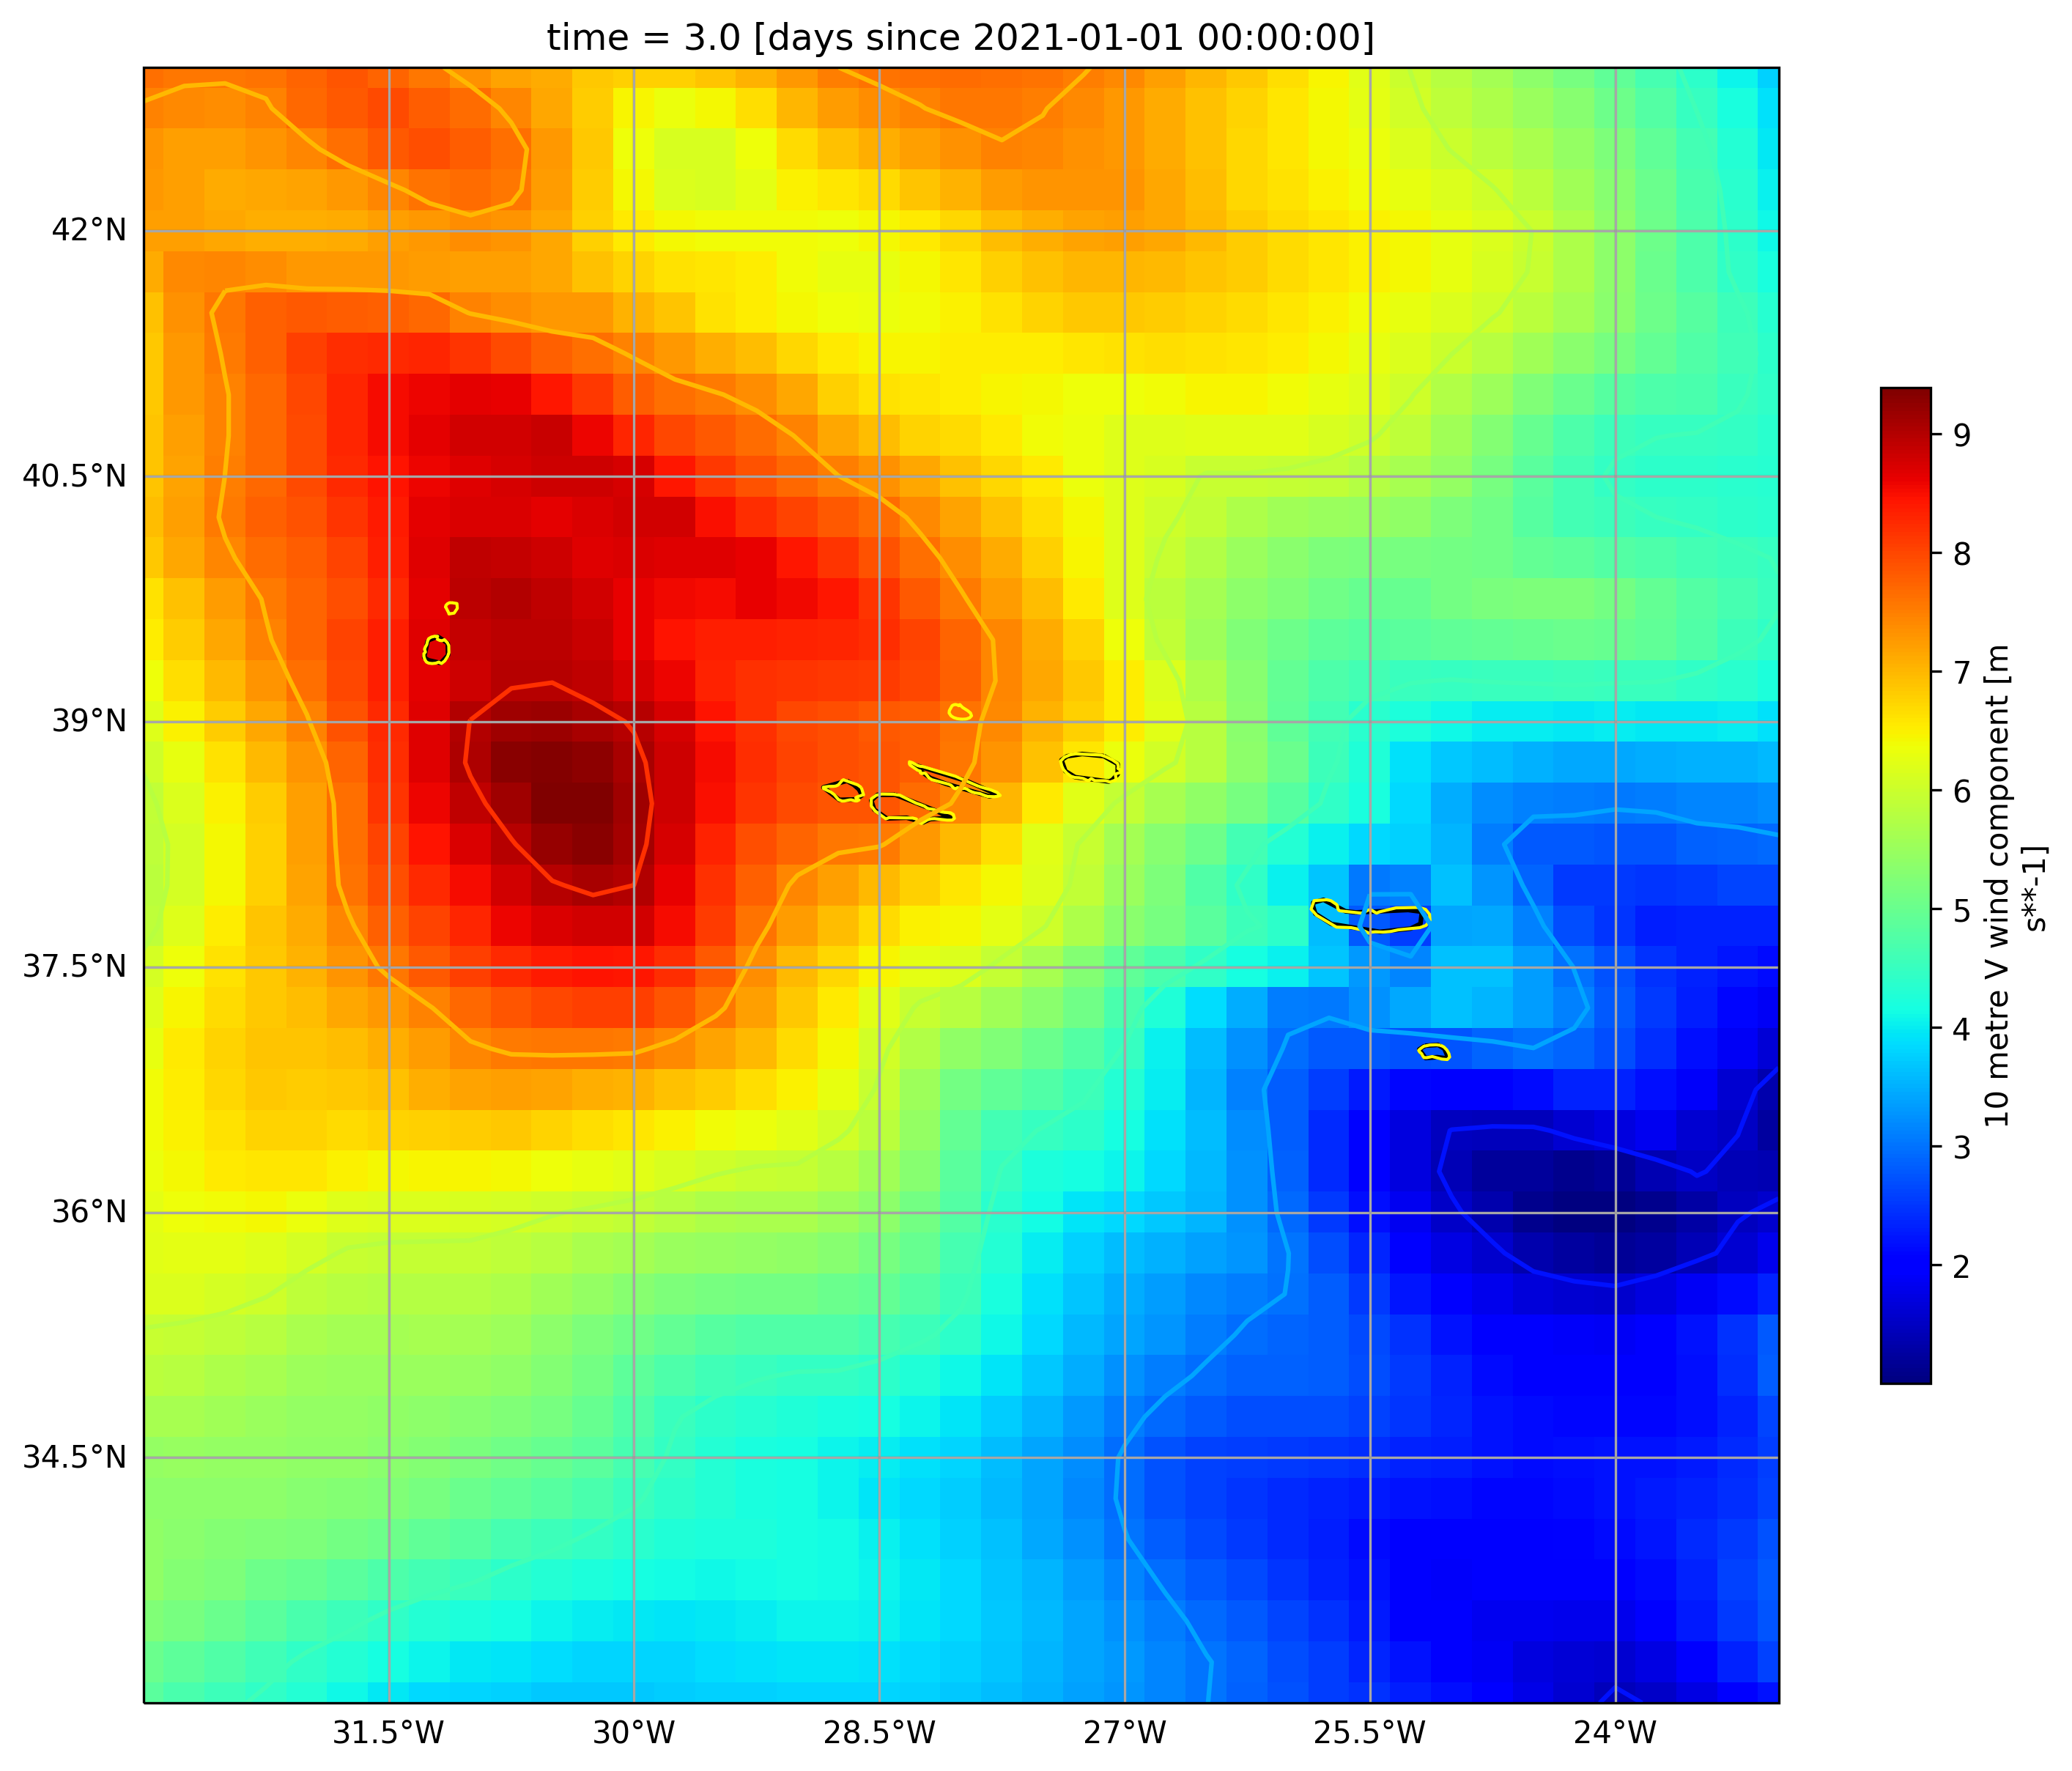

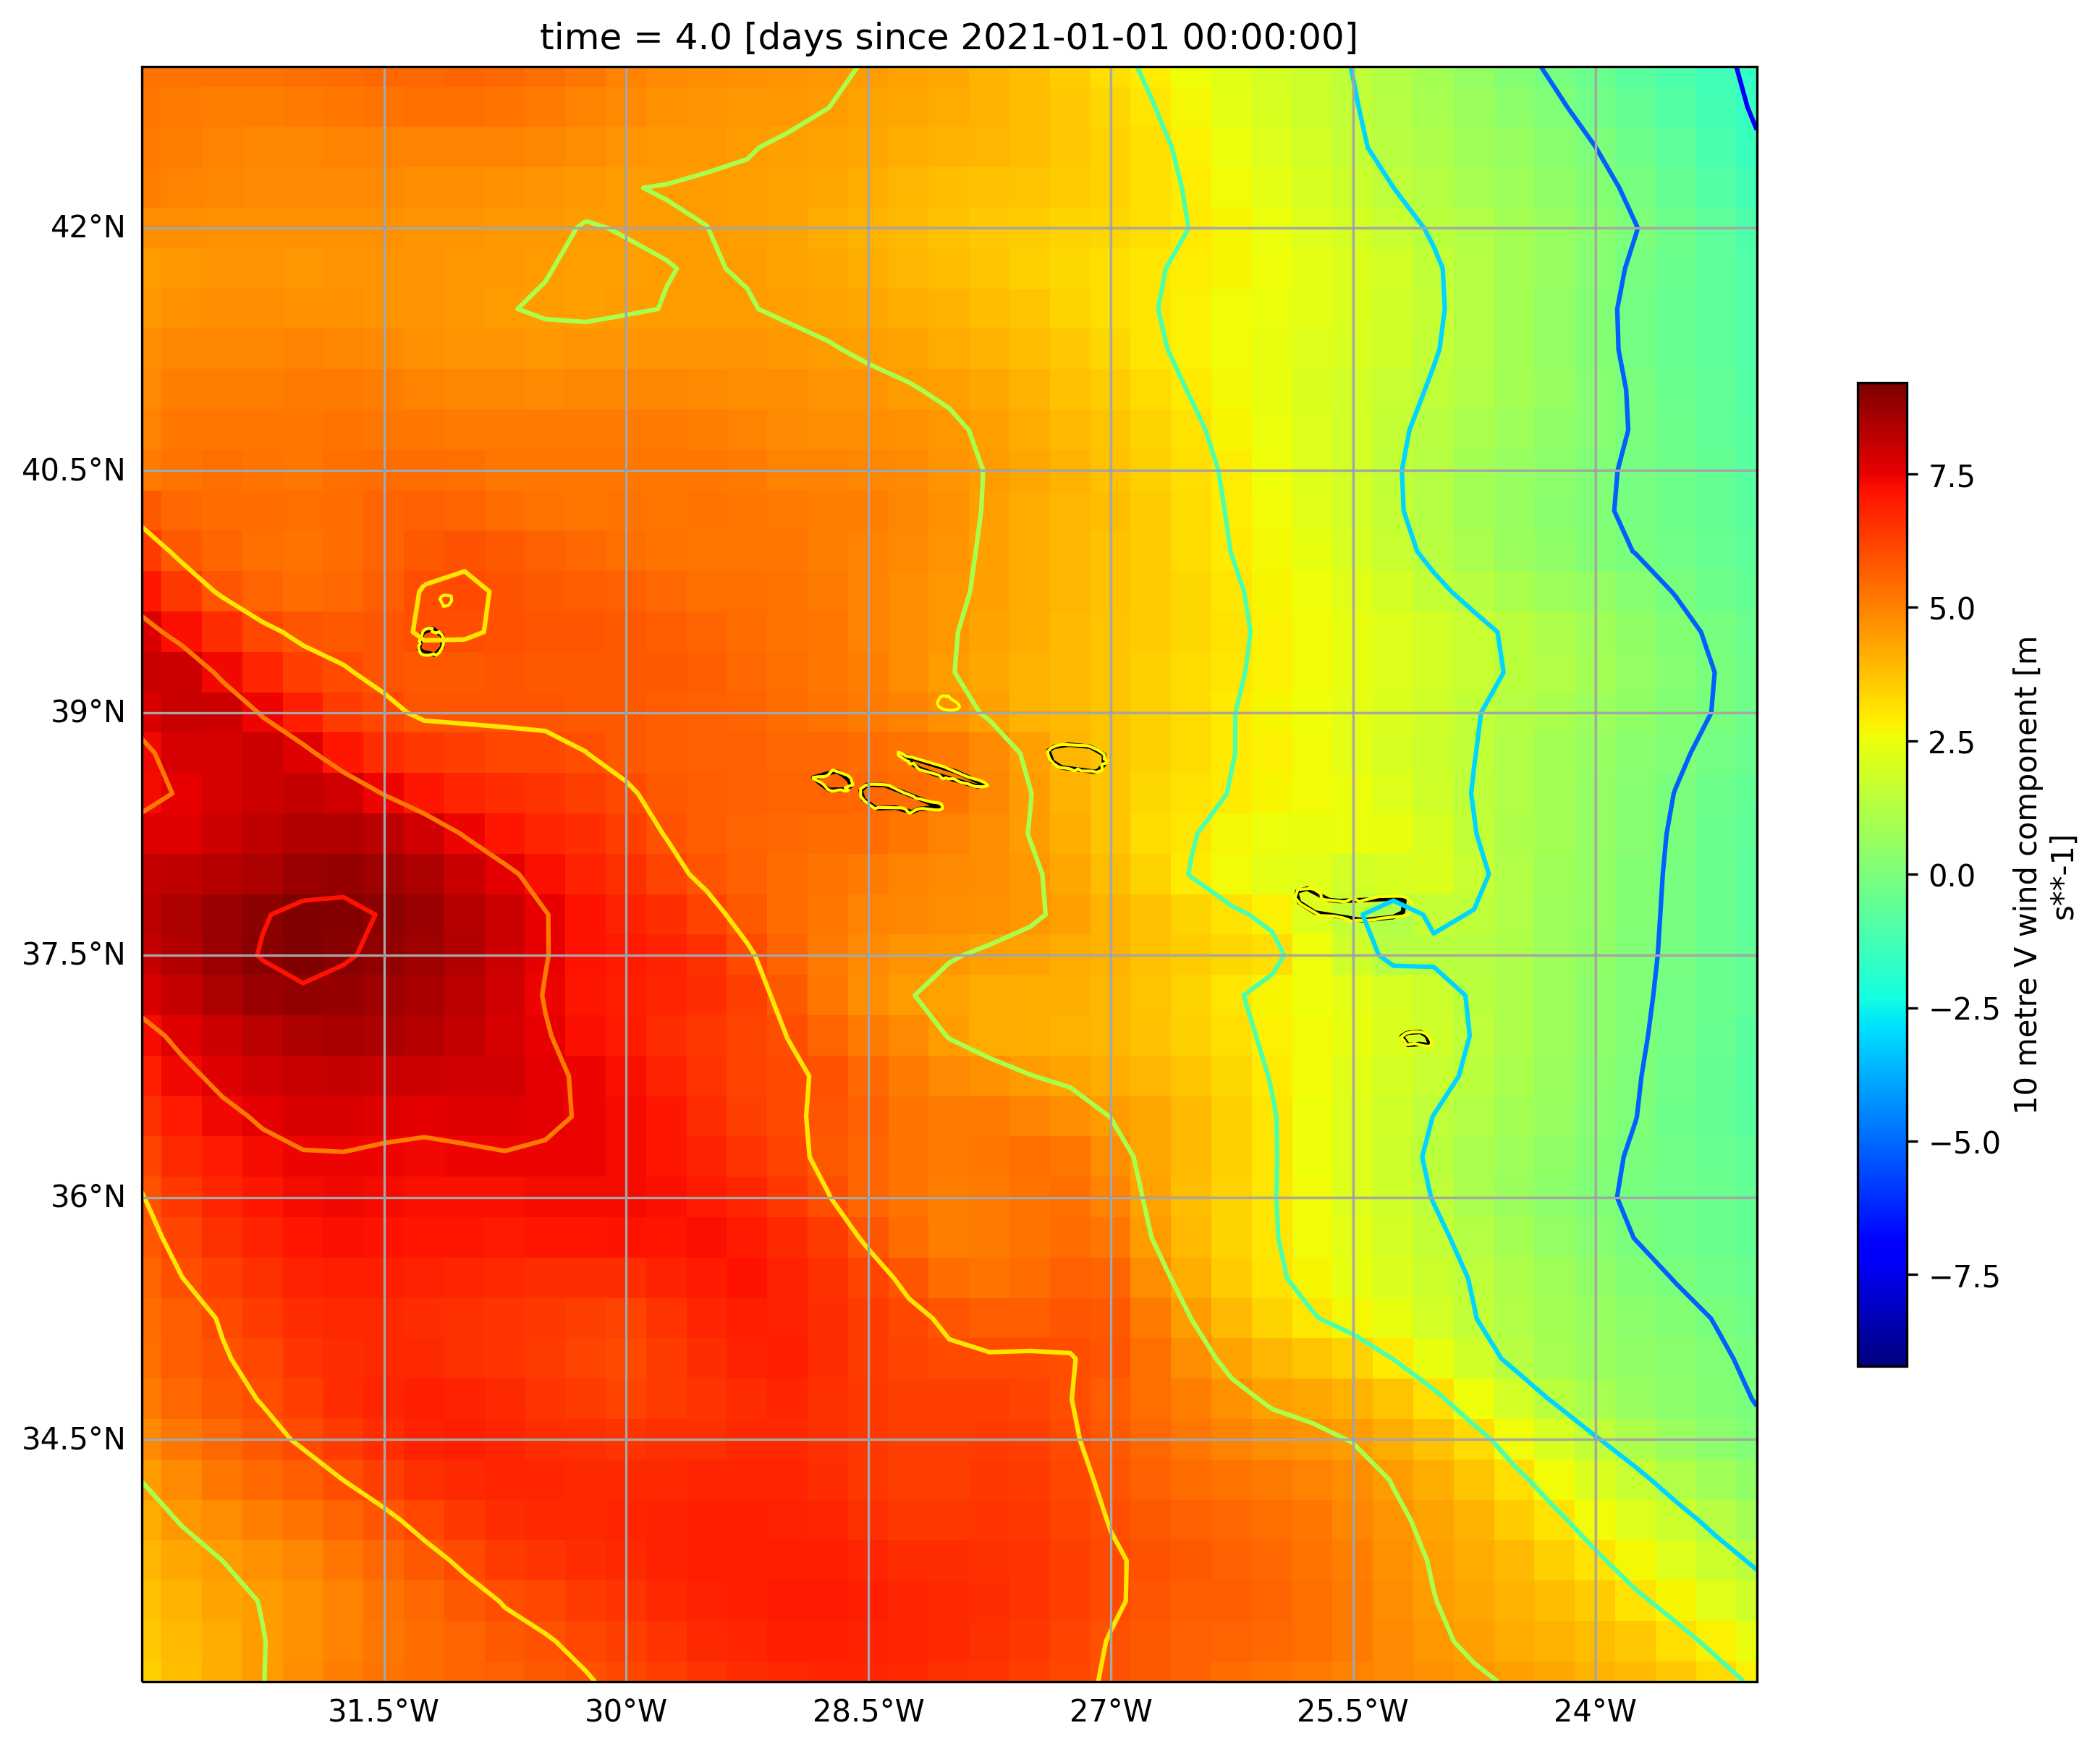

In [70]:
X=data.longitude; Y=data.latitude;

time = data.time;

for i in range(0, 5):
    sst=data.sst[i]; 
    t2m=data.t2m[i];
    sp=data.sp[i];
    u10=data.u10[i];
    v10=data.v10[i];
    sshf=data.sshf[i];
    slhf=data.slhf[i];
    nlon, nlat = np.meshgrid(X,Y)


    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

    # Add Plotting the plot
    ax=plt.subplot(111,projection=ccrs.PlateCarree())

    # Add Plot features
    ax.add_feature(cf.BORDERS, linewidth=0.9, edgecolor="yellow")
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cf.LAKES, edgecolor="blue")
    ax.add_feature(cf.LAND, edgecolor='black',)
    ax.add_feature(cf.OCEAN, edgecolor="blue")
    ax.add_feature(cf.BORDERS, edgecolor="yellow")
    ax.add_feature(cf.COASTLINE, edgecolor="yellow")
    ax.add_feature(cf.RIVERS, edgecolor="blue")
    ax.gridlines()

    #changing the location of the map
    #ax.set_extent([90, 141, 24, -10])

    # Add gridlines, and set their font size
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.05, linestyle='-')
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True

    #colorbar
    cmap = plt.get_cmap('jet') # Colour map coolwarm,hsv,bwr, seismic

    # # plotting the variables
    # sst.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, sst, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    # t2m.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, t2m, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    # sp.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, sp, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    # u10.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, u10, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    v10.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    plt.contour(nlon, nlat, v10, fontsize=10,cmap=cmap) #plotting the contours
    plt.show();


    #plotting the quiver
    #ax.quiver(X[::3],Y[::3],U[::3,::3],V[::3,::3], color='white')


   #plot title 
   #plt.title('Carbon Monoxide on October 22, 2019')
    #plt.savefig('fig_'+str(itime).rjust(3,'0')+'.png',bbox_inches='tight');
    #plt.show();
    # ----------------------------

In [47]:
def null_fill(input):

  dask_df = input.to_dask_dataframe(dim_order=None, set_index=False)
  pd_df = dask_df.compute()
  pd_df1 = pd_df.iloc[:, 3:]
  df2 = pd_df1[pd_df1.isnull().any(axis=1)]
  lst = list(df2.index.values)
  df2.loc[:] = np.nan
  dt = pd.concat([pd_df1, df2], axis=0)
  dt3 = dt[~dt.index.duplicated(keep='last')]
  dt4 = dt3[['sst', 'sp', 'u10', 'v10', 'sshf', 'slhf', 't2m']]
  pd_df4 = pd_df.iloc[:, 0:5]
  dff = pd_df4[['time', 'longitude', 'latitude', 'sst']]
  df = pd.merge(dff, dt4, left_index=True, right_index=True).drop('sst_y', axis=1)
  df.rename(columns={'sst_x':'sst'}, inplace=True)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)
  df_rows = pd.DataFrame(df).set_index(["time", "longitude", "latitude"])
  data = xr.Dataset.from_dataframe(df_rows)

  return data

In [48]:
data = null_fill(data)

In [49]:
detect_null(data)

Missing value detected in variable sst
Missing value detected in variable sp
Missing value detected in variable u10
Missing value detected in variable v10
Missing value detected in variable sshf
Missing value detected in variable slhf
Missing value detected in variable t2m


<xarray.Dataset>
Dimensions:    (time: 365, longitude: 41, latitude: 41)
Coordinates:
  * time       (time) float64 0.0 1.0 2.0 3.0 4.0 ... 361.0 362.0 363.0 364.0
  * longitude  (longitude) float64 -33.0 -32.75 -32.5 ... -23.5 -23.25 -23.0
  * latitude   (latitude) float64 33.0 33.25 33.5 33.75 ... 42.5 42.75 43.0
Data variables:
    sst        (time, longitude, latitude) float64 294.0 293.8 ... 289.4 289.2
    sp         (time, longitude, latitude) float64 1.015e+05 ... 9.893e+04
    u10        (time, longitude, latitude) float64 -2.685 -2.525 ... 6.352 6.21
    v10        (time, longitude, latitude) float64 5.305 4.99 ... 11.29 10.92
    sshf       (time, longitude, latitude) float64 -4.078e+04 ... -2.794e+04
    slhf       (time, longitude, latitude) float64 -3.481e+05 ... -6.7e+05
    t2m        (time, longitude, latitude) float64 292.6 292.5 ... 288.7 288.7

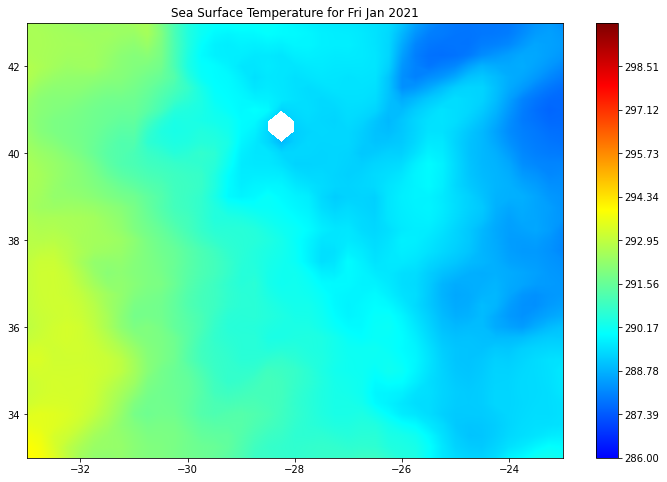

In [50]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)

levs = np.arange(286.0, 299.9, 0.05)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]

plt.contourf(data.longitude, data.latitude, data.sst[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("null imputed Sea Surface Temperature for " + dates[0].strftime('%a %b %Y'))
plt.show()

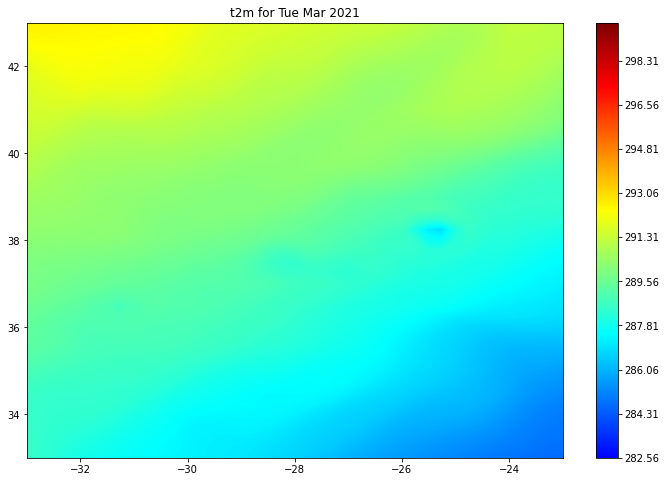

In [51]:
#np.nanmin(t2m), np.nanmax(t2m)(281.3474503204954, 298.9880612987922)
levs = np.arange(282.56, 299.818, 0.05)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(data.longitude, data.latitude, t2m[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("null imputed t2m for " + dates[67].strftime('%a %b %Y'))
plt.show()

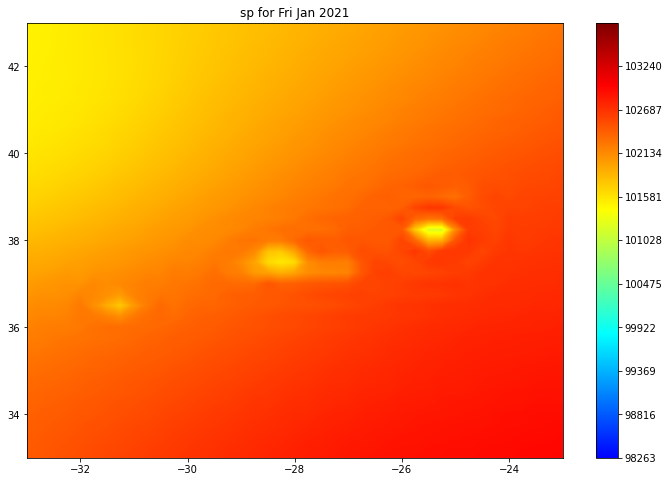

In [52]:
levs = np.arange(98262.56, 103788.818, 0.5) #(98261.56519393537, 103787.81869853102)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
plt.contourf(data.longitude, data.latitude, sp[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("null imputed sp for " + dates[0].strftime('%a %b %Y'))
plt.show()

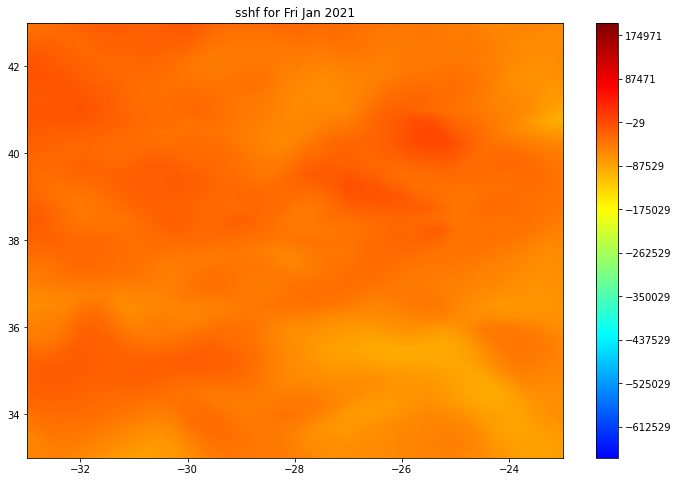

In [53]:
#np.nanmin(sshf), np.nanmax(sshf) (-674528.4583415989, 200023.0888483665)
levs = np.arange(-674529.45, 200024.08, 500)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
plt.contourf(data.longitude, data.latitude, sshf[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("null imputed sshf for " + dates[0].strftime('%a %b %Y'))
plt.show()


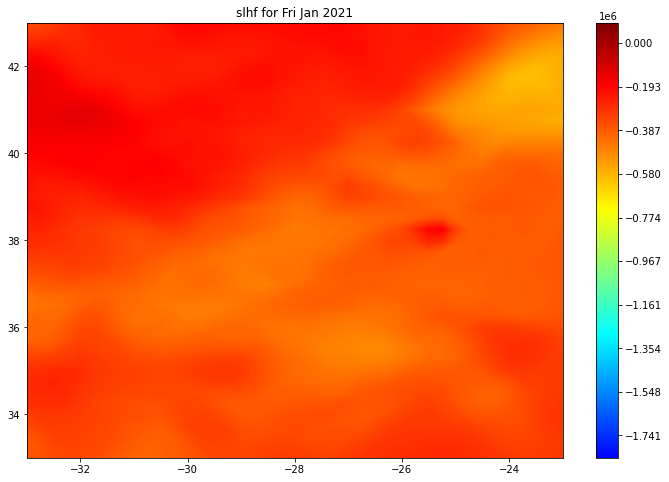

In [54]:
#np.nanmin(slhf), np.nanmax(slhf) (-1840906.950435913, 90130.6519768666)
levs = np.arange(-1840906.95, 90130.65, 500)
cm = LinearSegmentedColormap.from_list('my_jet', jet, N=len(levs))
jet=["blue", "#007FFF", "cyan","#7FFF7F", "yellow", "#FF7F00", "red", "#7F0000"]
plt.contourf(data.longitude, data.latitude, slhf[0,:,:], levs,cmap=cm)
plt.colorbar()
plt.title("null imputed slhf for " + dates[0].strftime('%a %b %Y'))
plt.show()


In [ ]:
#da=data.sel(latitude=sst.latitude, longitude=sst.longitude)

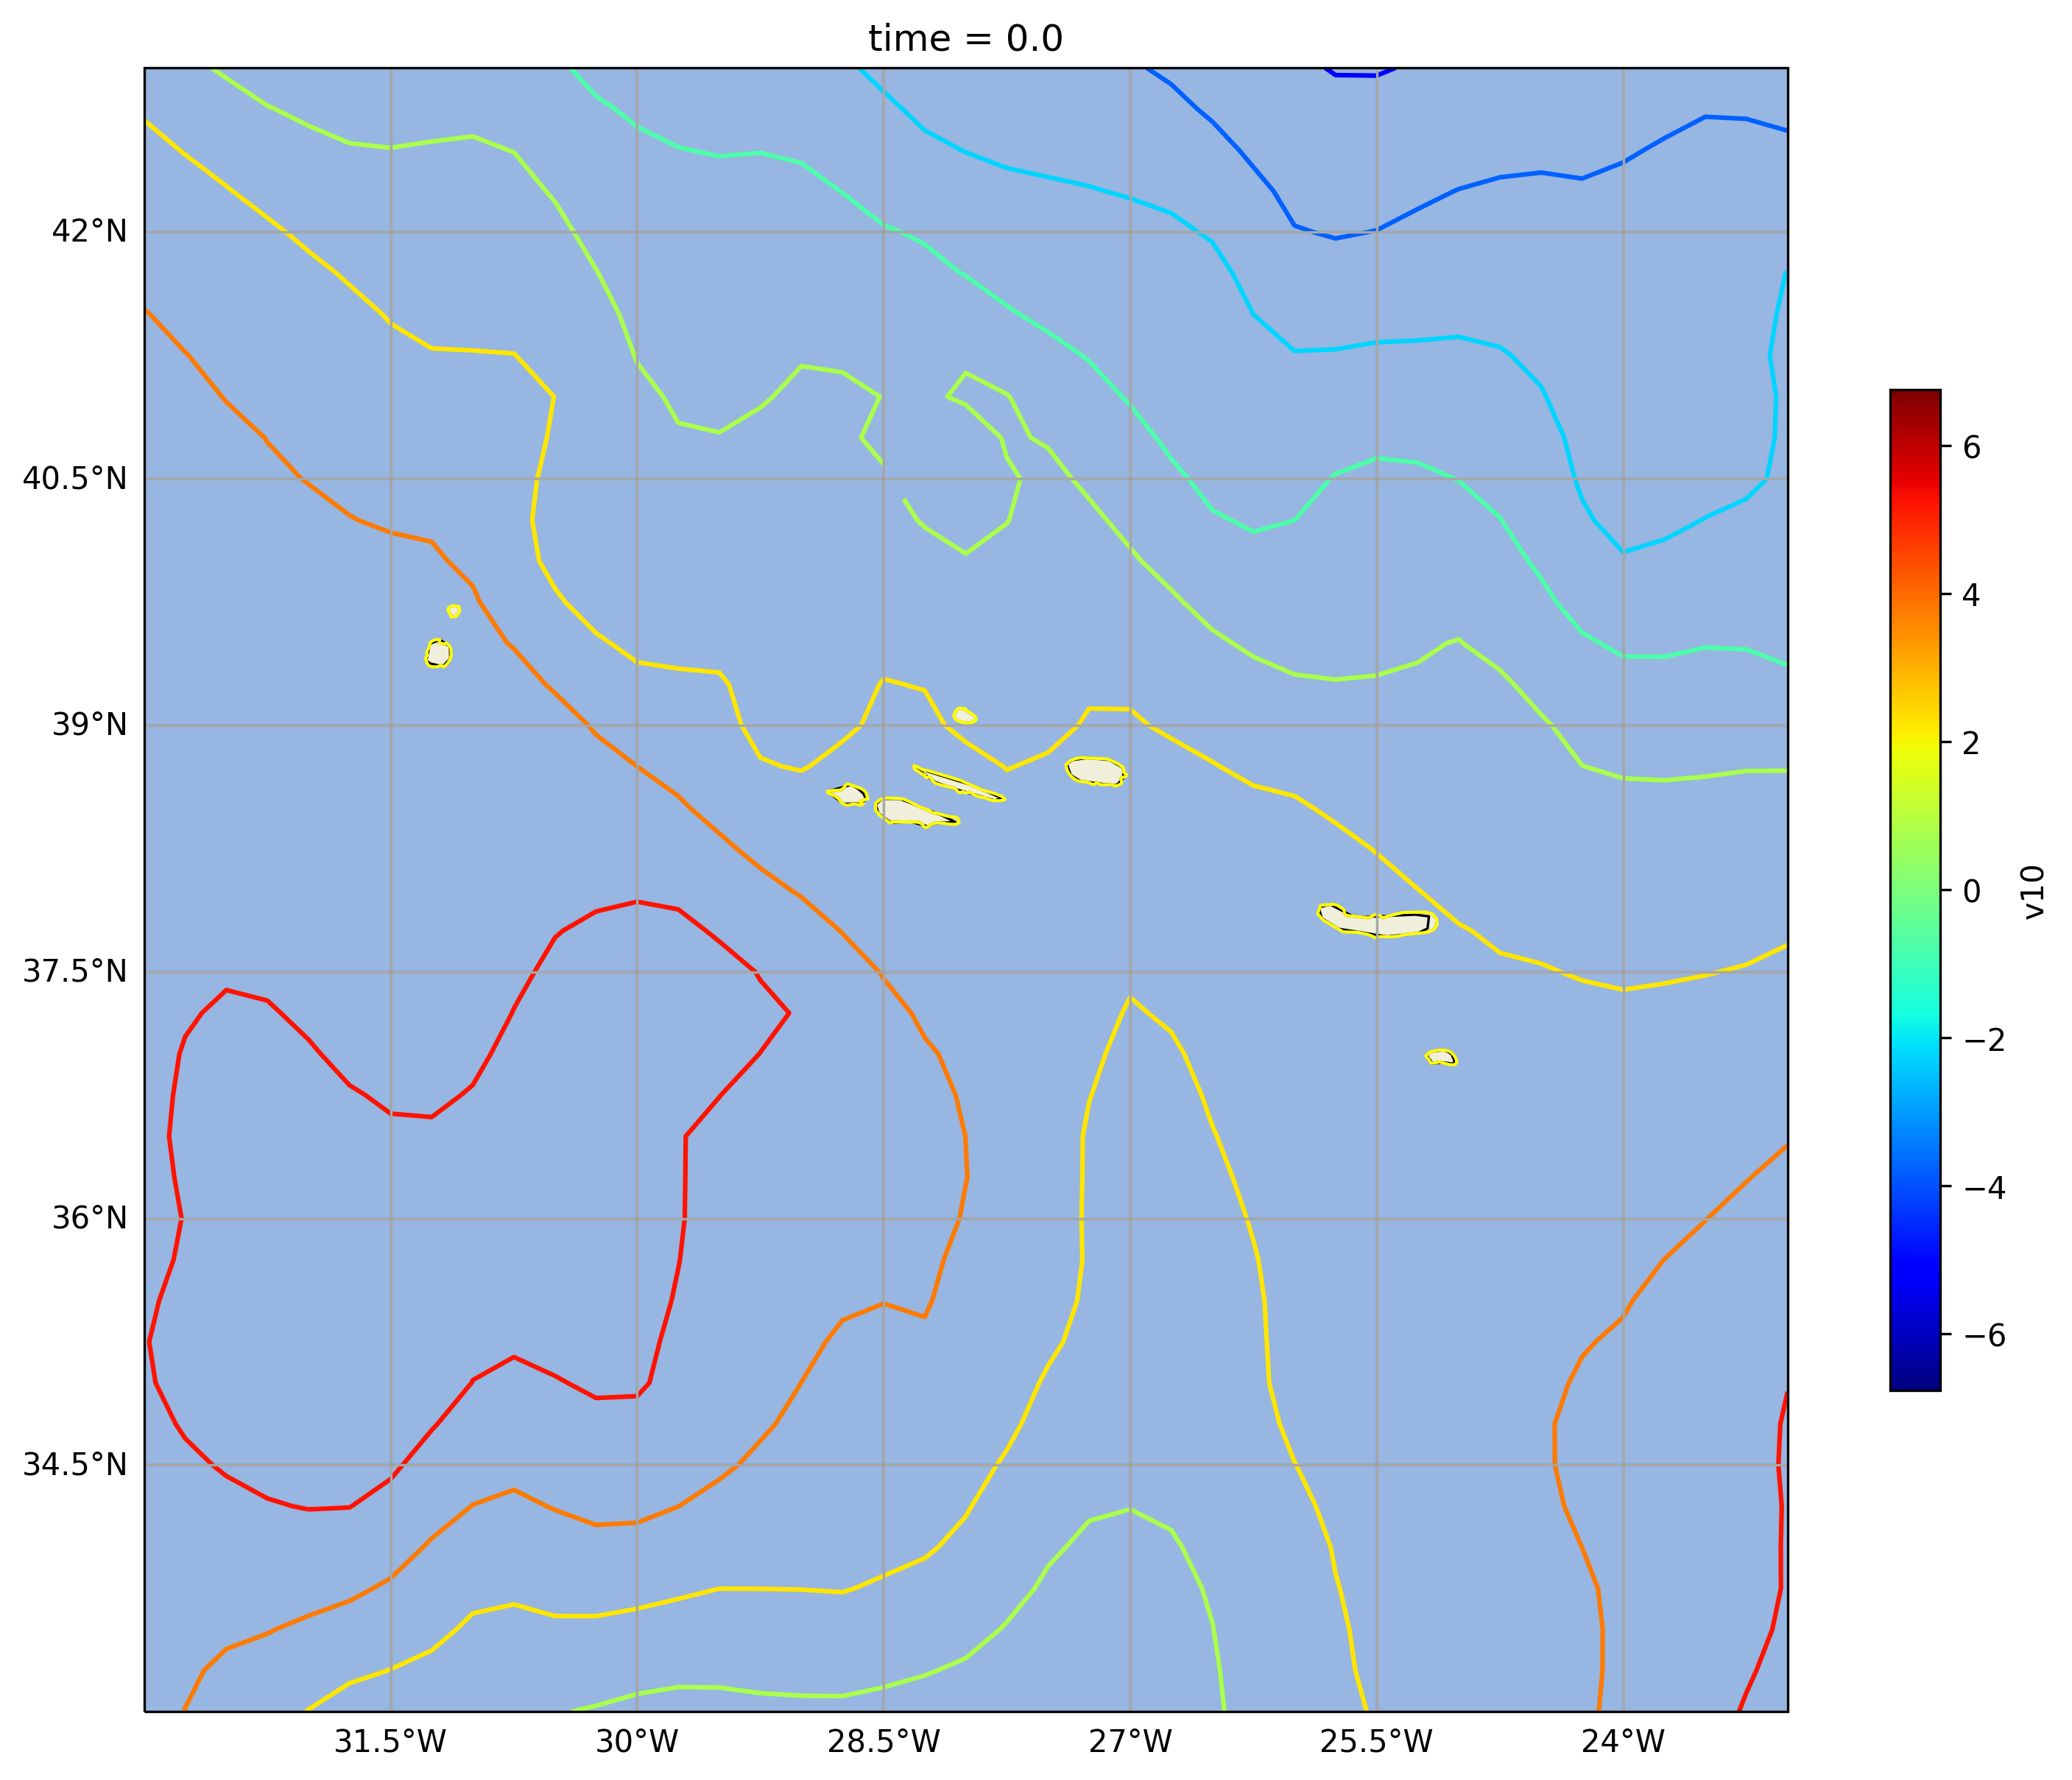

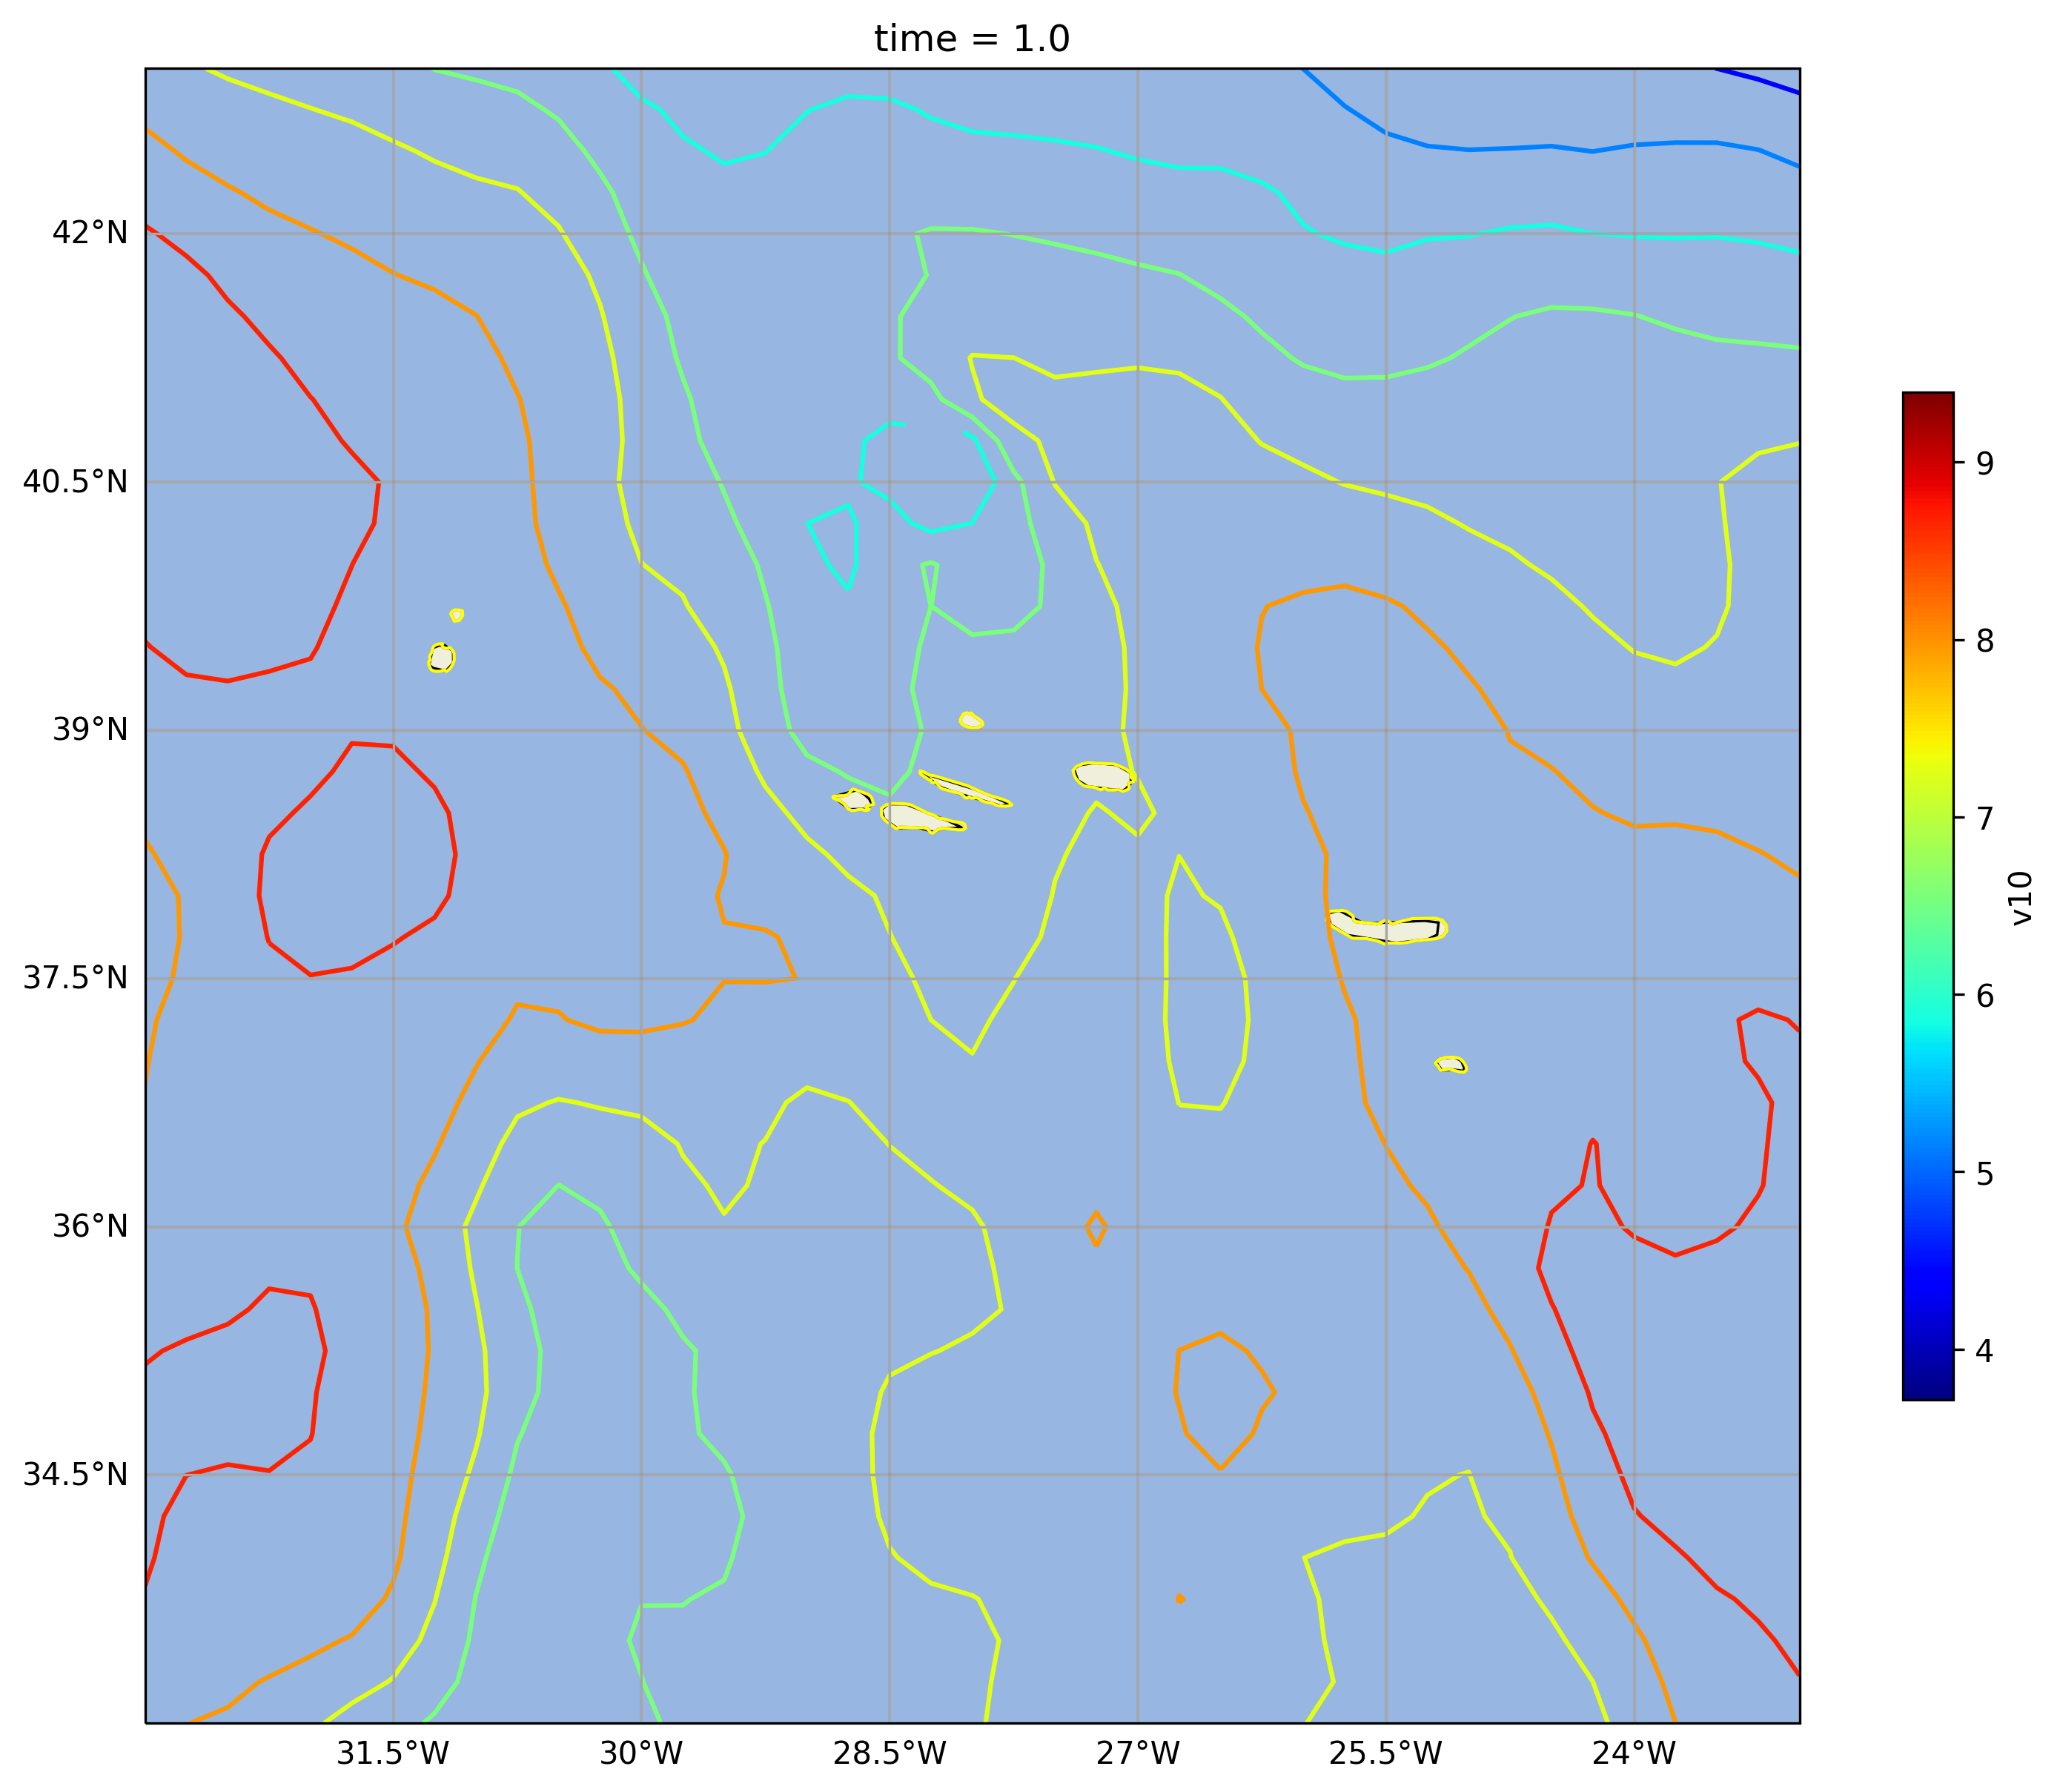

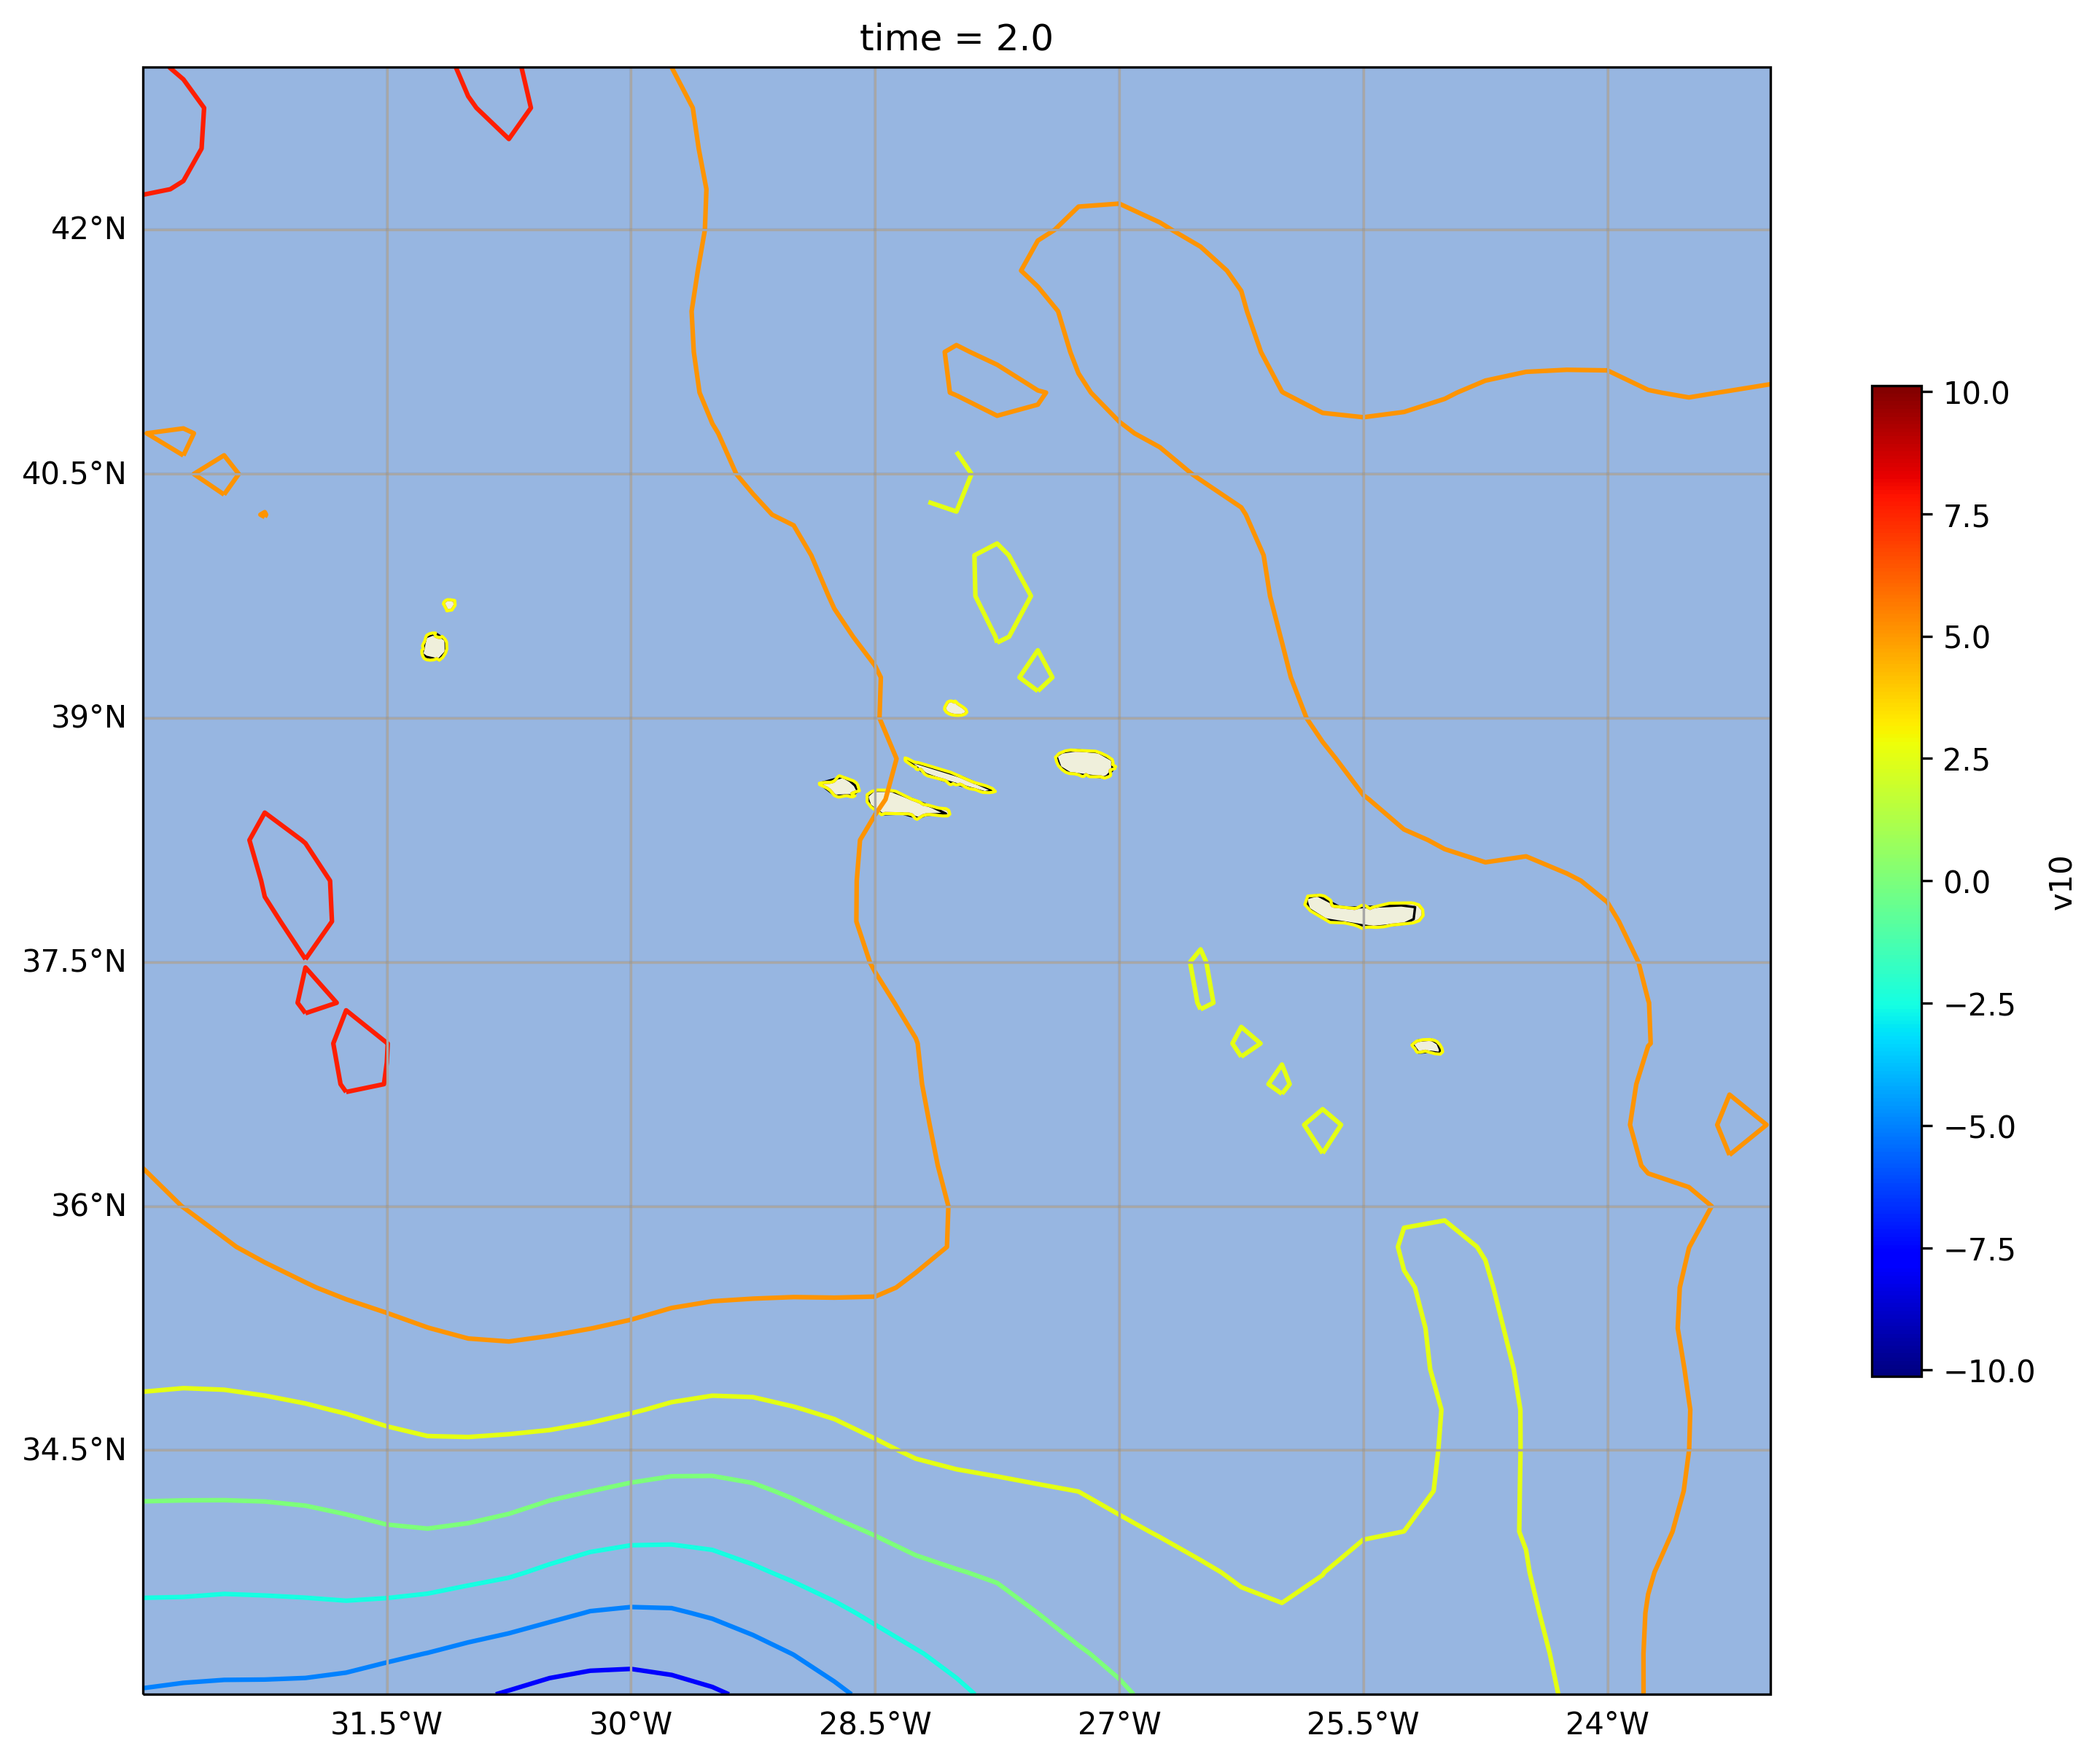

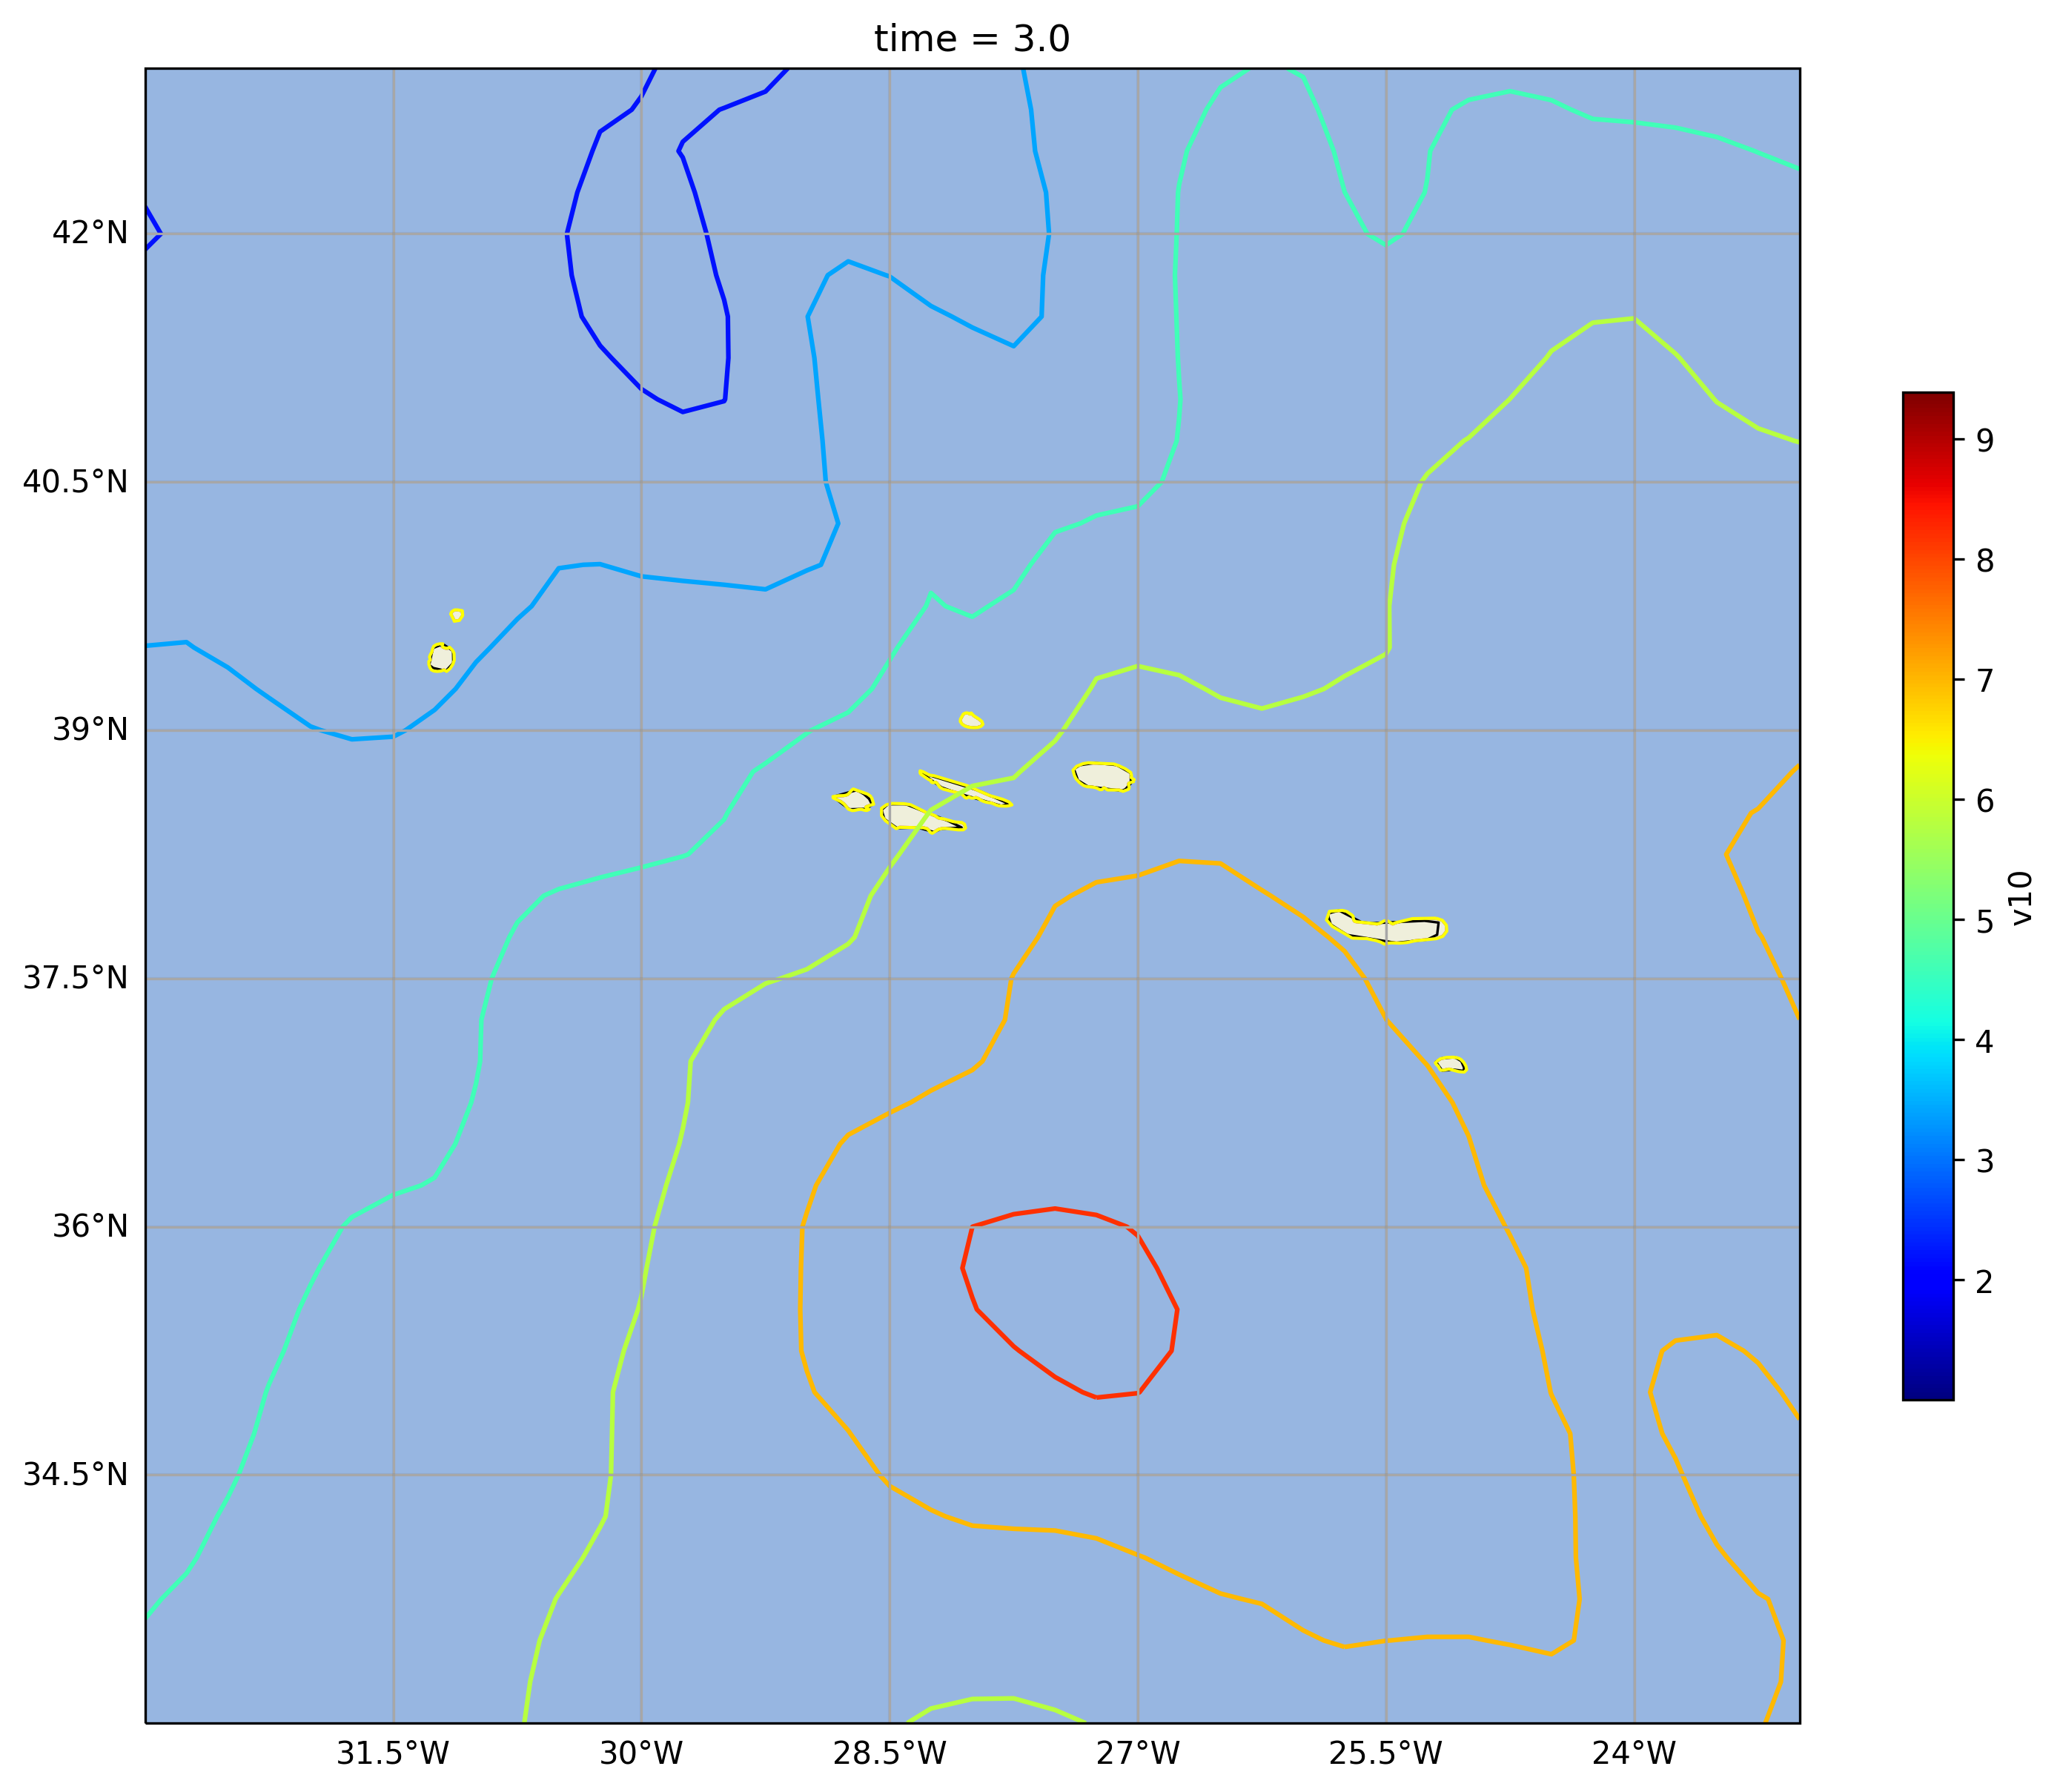

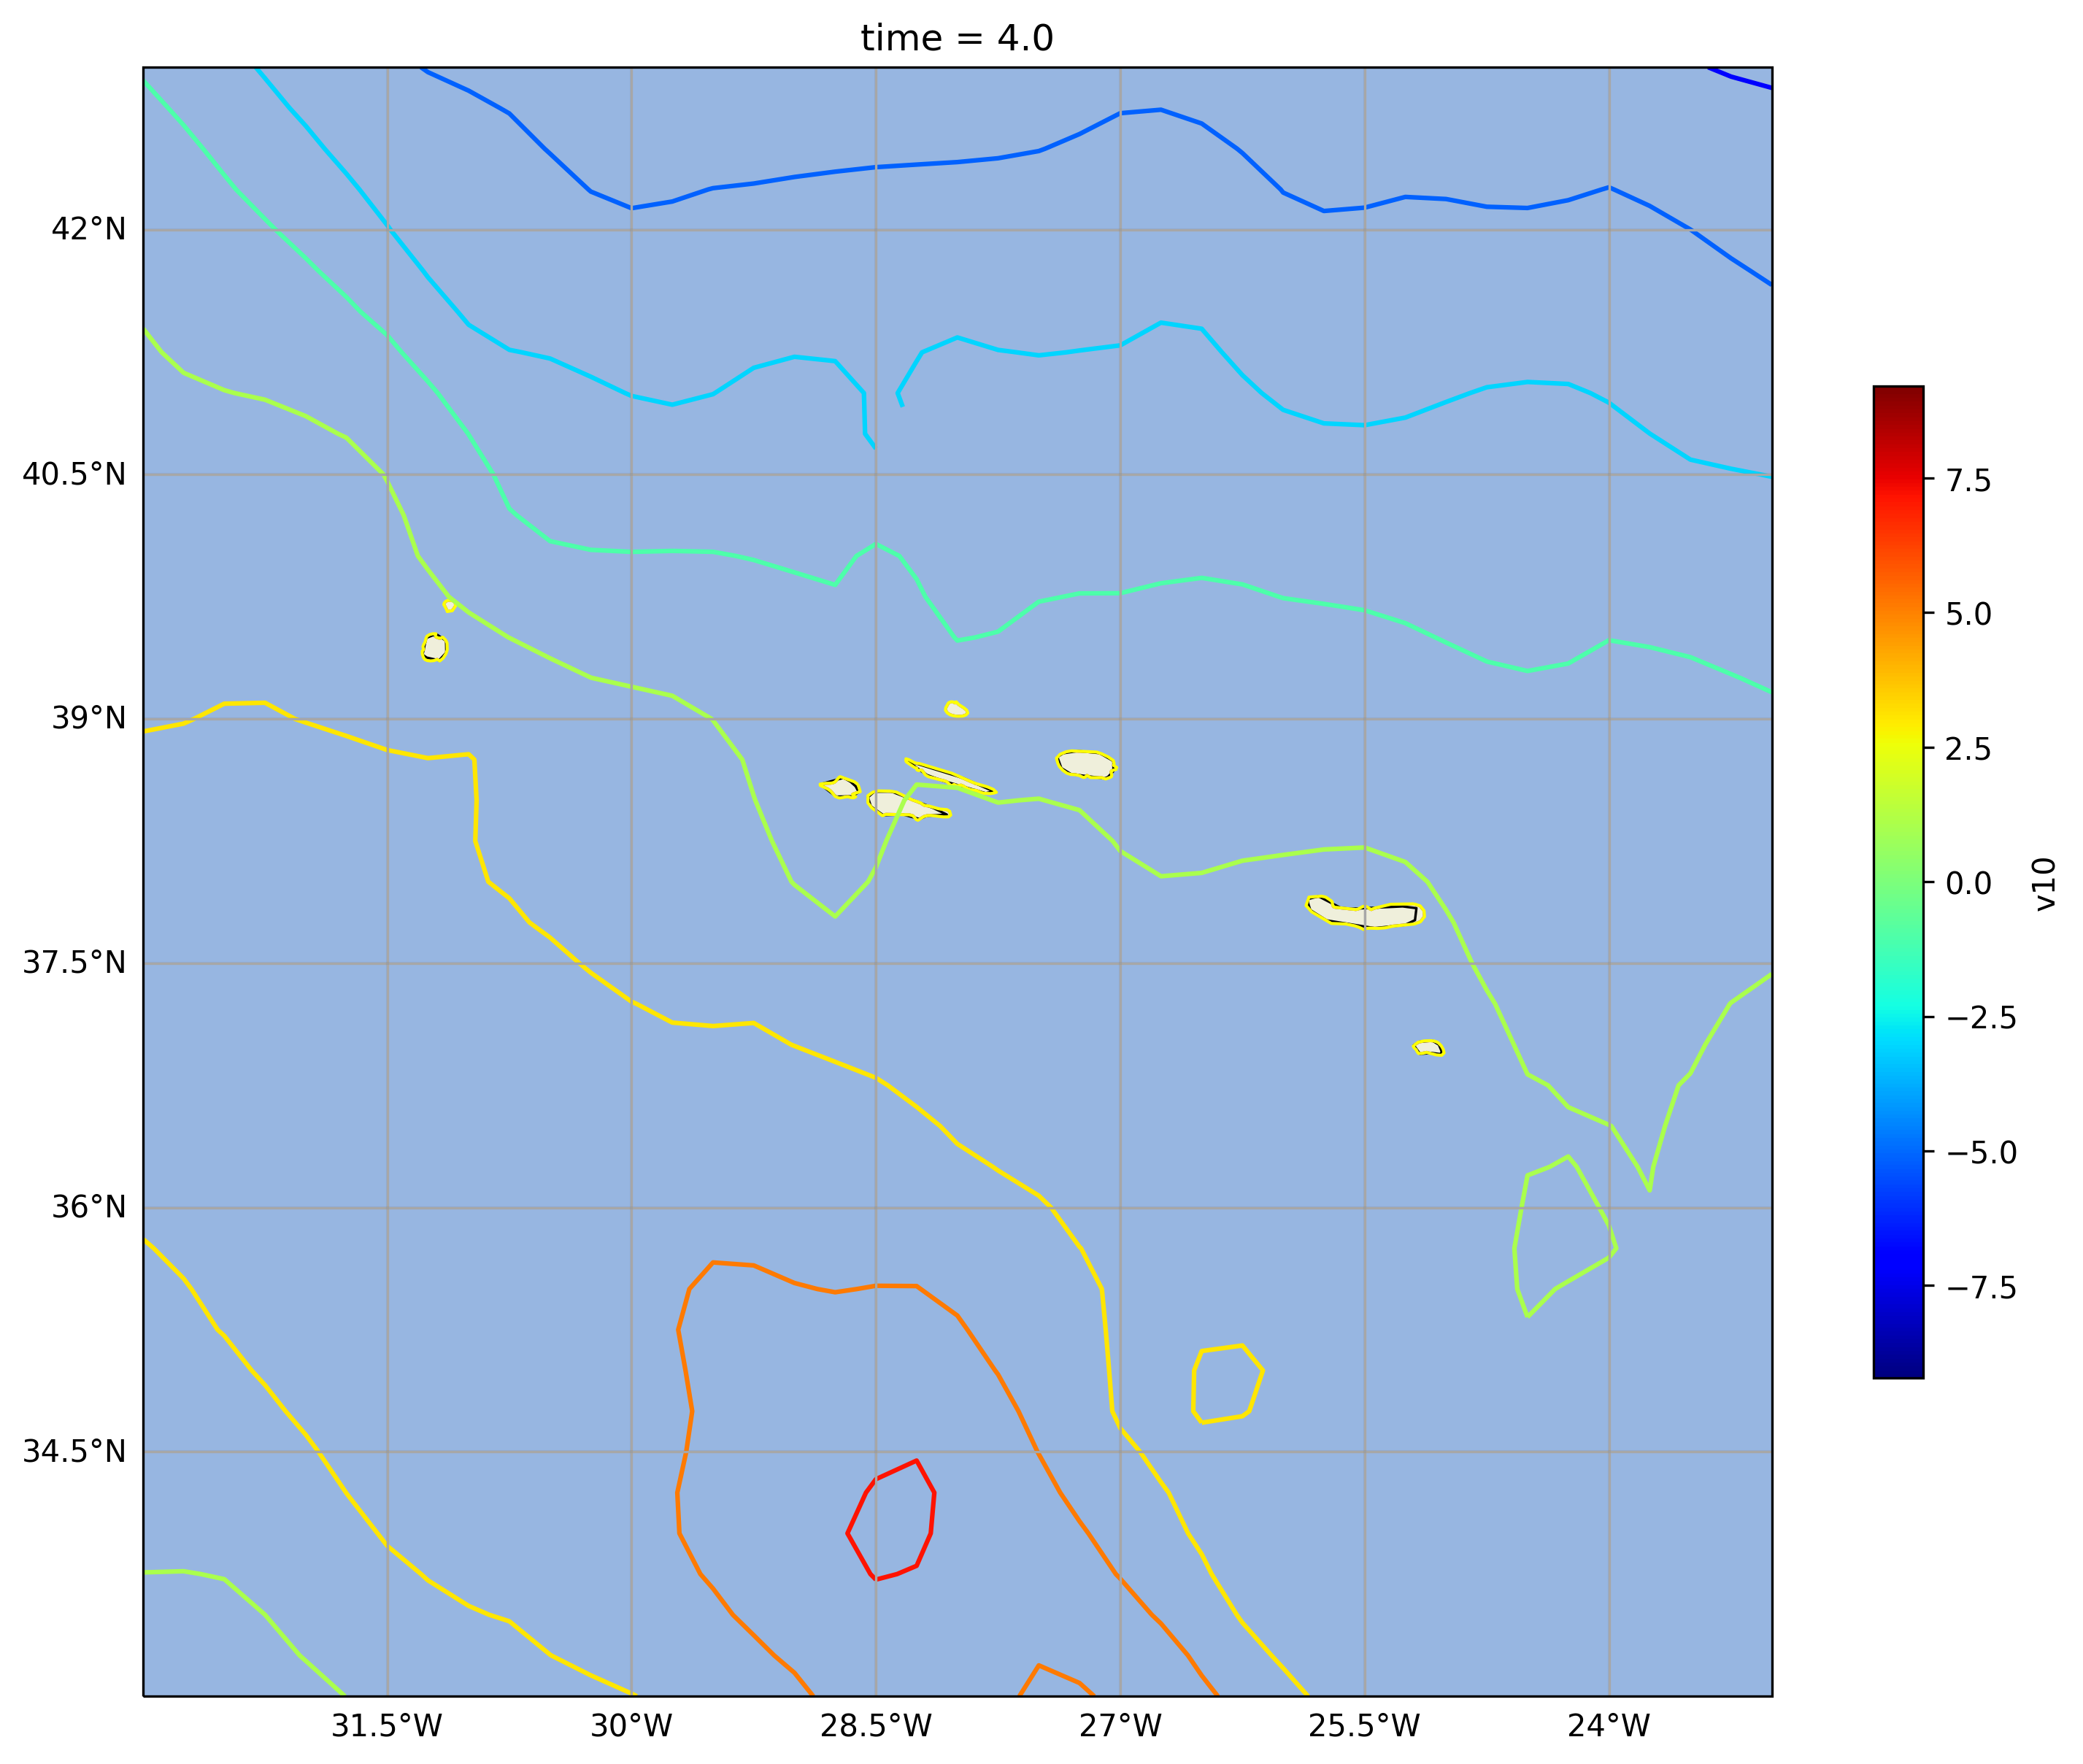

In [55]:
X=data.longitude; Y=data.latitude;

time = data.time;

for i in range(0, 5):
    sst=data.sst[i]; 
    t2m=data.t2m[i];
    sp=data.sp[i];
    u10=data.u10[i];
    v10=data.v10[i];
    sshf=data.sshf[i];
    slhf=data.slhf[i];
    nlon, nlat = np.meshgrid(X,Y)


    fig, ax = plt.subplots(figsize=(12, 12), dpi=300)

    # Add Plotting the plot
    ax=plt.subplot(111,projection=ccrs.PlateCarree())

    # Add Plot features
    ax.add_feature(cf.BORDERS, linewidth=0.9, edgecolor="yellow")
    ax.coastlines('50m', linewidth=1.5)
    ax.add_feature(cf.LAKES, edgecolor="blue")
    ax.add_feature(cf.LAND, edgecolor='black',)
    ax.add_feature(cf.OCEAN, edgecolor="blue")
    ax.add_feature(cf.BORDERS, edgecolor="yellow")
    ax.add_feature(cf.COASTLINE, edgecolor="yellow")
    ax.add_feature(cf.RIVERS, edgecolor="blue")
    ax.gridlines()

    #changing the location of the map
    #ax.set_extent([90, 141, 24, -10])

    # Add gridlines, and set their font size
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0.05, linestyle='-')
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels = False
    gl.xlines = True
    gl.ylines = True

    #colorbar
    cmap = plt.get_cmap('jet') # Colour map coolwarm,hsv,bwr, seismic

    # # plotting the variables
    # sst.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, sst, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    # t2m.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, t2m, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    # sp.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, sp, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    # u10.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    # plt.contour(nlon, nlat, u10, fontsize=10,cmap=cmap) #plotting the contours
    # plt.show();

    v10.plot(transform=ccrs.PlateCarree(), cbar_kwargs={'shrink': 0.5}, cmap=cmap)
    plt.contour(nlon, nlat, v10, fontsize=10,cmap=cmap) #plotting the contours
    plt.show();


    #plotting the quiver
    #ax.quiver(X[::3],Y[::3],U[::3,::3],V[::3,::3], color='white')


   #plot title 
   #plt.title('Carbon Monoxide on October 22, 2019')
    #plt.savefig('fig_'+str(itime).rjust(3,'0')+'.png',bbox_inches='tight');
    #plt.show();
    # ----------------------------